### Develop an ML Linear Regression model to learn High Entropy Alloy Hardness Property

In this tutorial we will learn to create an ML model for harness property prediction for high entropy alloys. We will go through the following steps:

Tutorial 3
1. Polynomial regression
2. Regularization
3. Hyper-parameter optimization



Tutorial 4
1. Normalization
2. Recursive feature elimination

### Importand python library imports

In [169]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import copy

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [171]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV

### 1. Load train data table

In [172]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

Downloading...
From: https://drive.google.com/uc?id=12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h
To: /content/alloy-confp-train-data_v2.csv
100% 7.33k/7.33k [00:00<00:00, 21.0MB/s]


In [173]:
data = pd.read_csv('alloy-confp-train-data_v2.csv')
data

ID   HV      C.al      C.co      C.cr      C.cu      C.fe      C.ni
0      7  139  0.000000  0.250000  0.250000  0.000000  0.250000  0.250000
1     48  295  0.153846  0.307692  0.153846  0.076923  0.153846  0.153846
2    108  545  0.222222  0.111111  0.000000  0.222222  0.222222  0.222222
3    146  701  0.428571  0.214286  0.071429  0.071429  0.071429  0.142857
4     37  207  0.090909  0.181818  0.181818  0.181818  0.181818  0.181818
..   ...  ...       ...       ...       ...       ...       ...       ...
115   42  249  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667
116   72  450  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059
117   73  451  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667
118  135  617  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667
119   28  171  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575

[120 rows x 8 columns]

#### Notes about the data table

Above we see that data table has 3 types of columns:
1. ID: Serial number of the alloys.
2. HV: This is the experimentally measured hardness values of the alloys. Our target property (y).    
3. C.*: concentration of different elements in the alloys.

#### Separate X and y data

In [174]:
Xcols = data.columns[data.columns.str.contains("C.")]
X = data[Xcols]
X

C.al      C.co      C.cr      C.cu      C.fe      C.ni
0    0.000000  0.250000  0.250000  0.000000  0.250000  0.250000
1    0.153846  0.307692  0.153846  0.076923  0.153846  0.153846
2    0.222222  0.111111  0.000000  0.222222  0.222222  0.222222
3    0.428571  0.214286  0.071429  0.071429  0.071429  0.142857
4    0.090909  0.181818  0.181818  0.181818  0.181818  0.181818
..        ...       ...       ...       ...       ...       ...
115  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667
116  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059
117  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667
118  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667
119  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575

[120 rows x 6 columns]

In [175]:
y = data['HV']
y

0      139
1      295
2      545
3      701
4      207
      ... 
115    249
116    450
117    451
118    617
119    171
Name: HV, Length: 120, dtype: int64

### 2. Visualize data

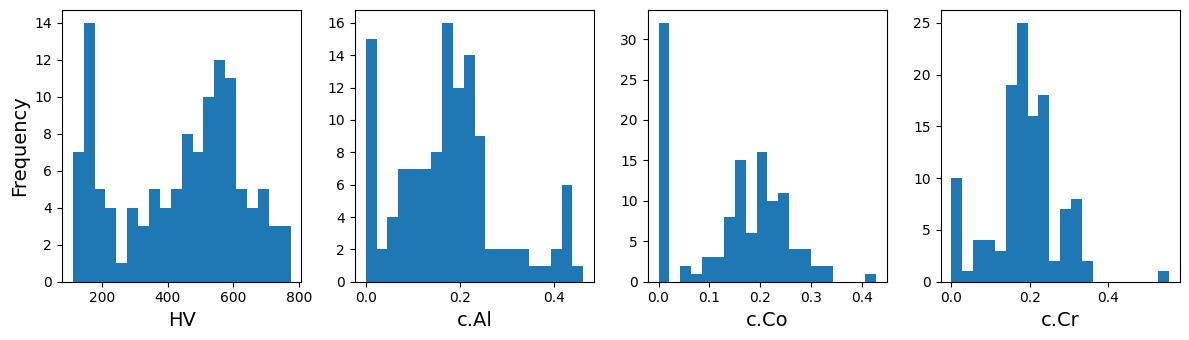

In [176]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5))

ax1.hist(y.values, bins=20)
ax2.hist(X.values[:,0], bins=20, label='c.Al')
ax3.hist(X.values[:,1], bins=20, label='c.Co')
ax4.hist(X.values[:,2], bins=20, label='c.Cr')

ax1.set_xlabel('HV', fontsize=14)
ax2.set_xlabel('c.Al', fontsize=14)
ax3.set_xlabel('c.Co', fontsize=14)
ax4.set_xlabel('c.Cr', fontsize=14)

ax1.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

### 3. Train an ML model

In [177]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """

    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)

    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)

    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])

    if y_cv_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)

        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    plt.tight_layout()
    plt.show()

    return None

#### Our own LR code using the equation discused in class

In [178]:
X_tras_X_inv = np.linalg.inv(np.dot(X.T,X))
X_tras_y = np.dot(X.T,y)
w_cap_vec = np.dot(X_tras_X_inv,X_tras_y)
y_pred_manual = np.dot(X,w_cap_vec)

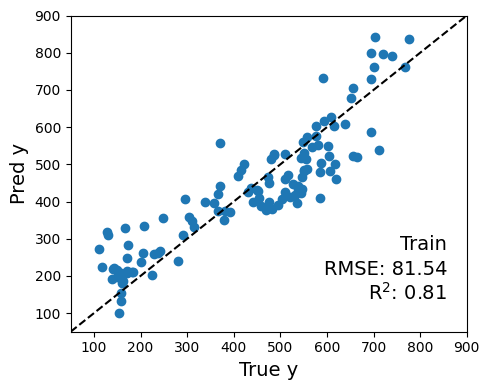

In [179]:
polt_parity(y,y_pred_manual, label="Train")

#### Using sklearn in-built python library

In [180]:
lr = LinearRegression(fit_intercept=False)
model = lr.fit(X,y)
lr_model = copy.deepcopy(model)

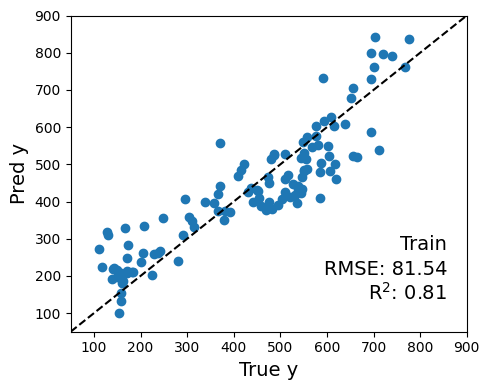

In [181]:
y_pred = model.predict(X)
polt_parity(y,y_pred, label="Train")

#### Comparing sklearn library vs our equation results

In [182]:
print("Sklearn model: ", lr_model.coef_)
print("Eq. based model: ", w_cap_vec)

Sklearn model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]
Eq. based model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]


#### Error with baseline average model

In [183]:
y_avg_pred = [y.mean()]*len(y)
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y, y_avg_pred)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_avg_pred))

Root mean squared error: 186.35
Coefficient of determination: 0.00


### 4. Model assessment, cross-validation

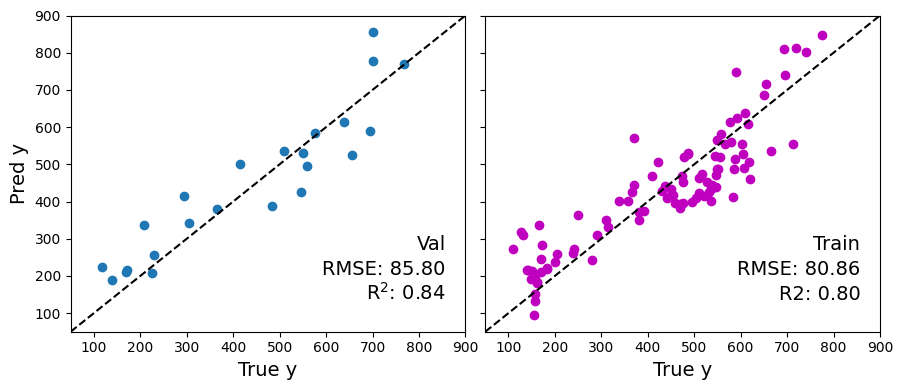

Root mean squared error: 85.80
Coefficient of determination: 0.84


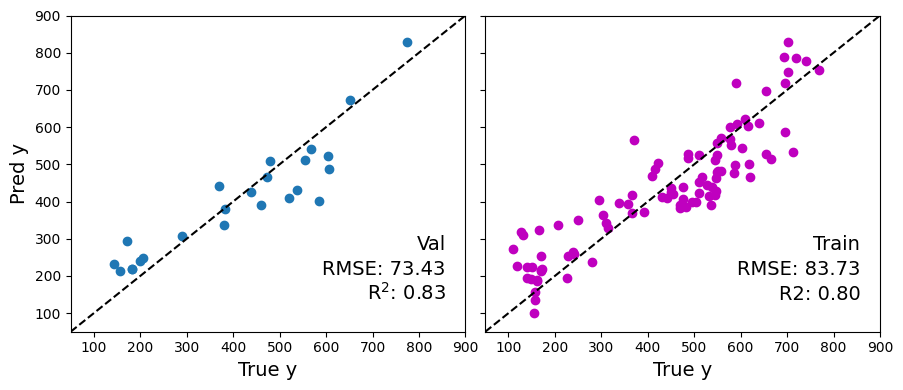

Root mean squared error: 73.43
Coefficient of determination: 0.83


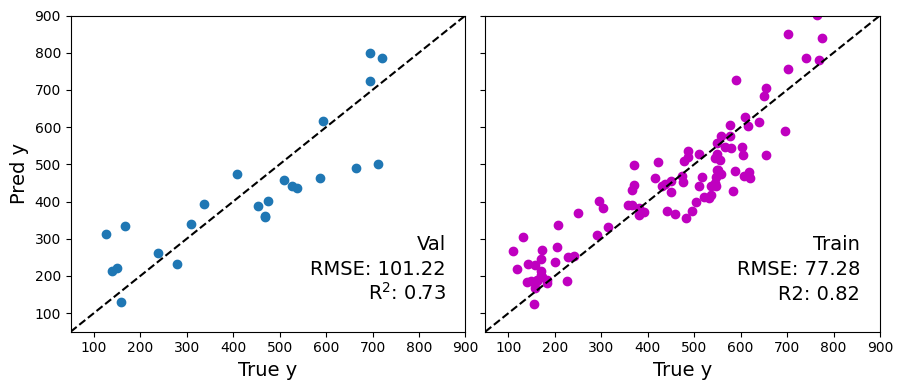

Root mean squared error: 101.22
Coefficient of determination: 0.73


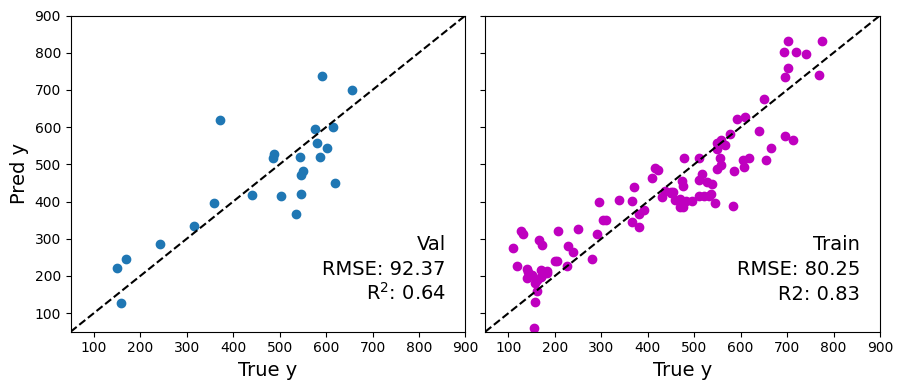

Root mean squared error: 92.37
Coefficient of determination: 0.64


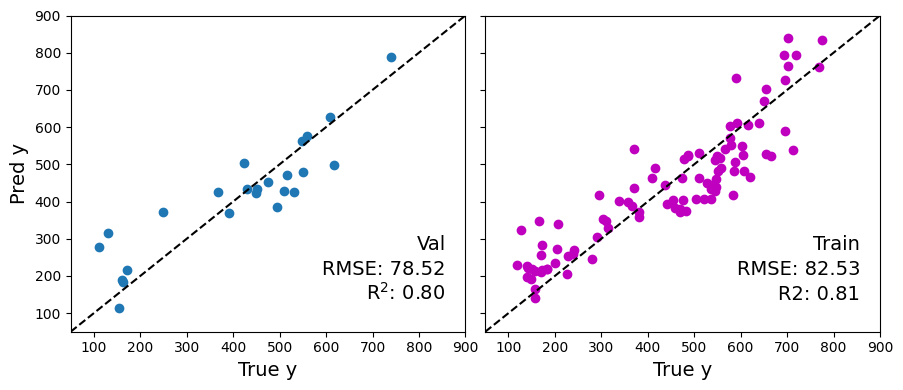

Root mean squared error: 78.52
Coefficient of determination: 0.80


In [184]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [185]:
errors = pd.DataFrame(errors)
errors

kfold  rmse_train  r2_train    rmse_val    r2_val
0      1   80.864286  0.795547   85.799257  0.837913
1      2   83.732501  0.800274   73.432834  0.834738
2      3   77.280666  0.823255  101.215500  0.733636
3      4   80.246476  0.826733   92.368961  0.638148
4      5   82.527396  0.807746   78.516907  0.801528

In [186]:
errors[['rmse_val','r2_val']].mean()

rmse_val    86.266692
r2_val       0.769193
dtype: float64

## Start of Tutorial 3

In this tutorial we would learn
1. Polynomial regression improves model accuracy
2. Regularization
3. How to determine lambda coefficient for regularization
4. Normalization
5. Comparing all models

### Building polynomial features

In [187]:
new_data = data.copy()

In [188]:
def make_new_feature(data, cols, powers, new_col_name):
    data[new_col_name] = 1
    for power, col in zip(powers, cols):
        data[new_col_name] = data[new_col_name] * (data[Xcols[col]] ** power)

    return data

In [189]:
cols = [0,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.1')

In [190]:
new_data

ID   HV      C.al      C.co      C.cr      C.cu      C.fe      C.ni  \
0      7  139  0.000000  0.250000  0.250000  0.000000  0.250000  0.250000   
1     48  295  0.153846  0.307692  0.153846  0.076923  0.153846  0.153846   
2    108  545  0.222222  0.111111  0.000000  0.222222  0.222222  0.222222   
3    146  701  0.428571  0.214286  0.071429  0.071429  0.071429  0.142857   
4     37  207  0.090909  0.181818  0.181818  0.181818  0.181818  0.181818   
..   ...  ...       ...       ...       ...       ...       ...       ...   
115   42  249  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667   
116   72  450  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059   
117   73  451  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667   
118  135  617  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667   
119   28  171  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575   

          n.1  
0    0.000000  
1    0.047337  
2    0.024691  
3    0.091837  
4    0.016529  
..        ...  
115  0.055556  
116  0.000000  
117  0.041667  
118  0.027778  
119  0.000000  

[120 rows x 9 columns]

In [191]:
cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.2')

cols = [2,4]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'n.3')

cols = [3,4,5]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.4')

cols = [4,5]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.5')

In [192]:
new_data

ID   HV      C.al      C.co      C.cr      C.cu      C.fe      C.ni  \
0      7  139  0.000000  0.250000  0.250000  0.000000  0.250000  0.250000   
1     48  295  0.153846  0.307692  0.153846  0.076923  0.153846  0.153846   
2    108  545  0.222222  0.111111  0.000000  0.222222  0.222222  0.222222   
3    146  701  0.428571  0.214286  0.071429  0.071429  0.071429  0.142857   
4     37  207  0.090909  0.181818  0.181818  0.181818  0.181818  0.181818   
..   ...  ...       ...       ...       ...       ...       ...       ...   
115   42  249  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667   
116   72  450  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059   
117   73  451  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667   
118  135  617  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667   
119   28  171  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575   

          n.1       n.2       n.3       n.4       n.5  
0    0.000000  0.000000  0.015625  0.000000  0.062500  
1    0.047337  0.023669  0.003641  0.001821  0.023669  
2    0.024691  0.024691  0.000000  0.010974  0.049383  
3    0.091837  0.015306  0.000364  0.000729  0.010204  
4    0.016529  0.033058  0.006011  0.006011  0.033058  
..        ...       ...       ...       ...       ...  
115  0.055556  0.055556  0.000000  0.004630  0.027778  
116  0.000000  0.000000  0.057246  0.000000  0.064879  
117  0.041667  0.020833  0.004630  0.002315  0.027778  
118  0.027778  0.000000  0.009259  0.000000  0.027778  
119  0.000000  0.045188  0.004764  0.006765  0.031823  

[120 rows x 13 columns]

In [193]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("n.")]
X = new_data[Xcols]
X

C.al      C.co      C.cr      C.cu      C.fe      C.ni       n.1  \
0    0.000000  0.250000  0.250000  0.000000  0.250000  0.250000  0.000000   
1    0.153846  0.307692  0.153846  0.076923  0.153846  0.153846  0.047337   
2    0.222222  0.111111  0.000000  0.222222  0.222222  0.222222  0.024691   
3    0.428571  0.214286  0.071429  0.071429  0.071429  0.142857  0.091837   
4    0.090909  0.181818  0.181818  0.181818  0.181818  0.181818  0.016529   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667  0.055556   
116  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059  0.000000   
117  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667  0.041667   
118  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667  0.027778   
119  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575  0.000000   

          n.2       n.3       n.4       n.5  
0    0.000000  0.015625  0.000000  0.062500  
1    0.023669  0.003641  0.001821  0.023669  
2    0.024691  0.000000  0.010974  0.049383  
3    0.015306  0.000364  0.000729  0.010204  
4    0.033058  0.006011  0.006011  0.033058  
..        ...       ...       ...       ...  
115  0.055556  0.000000  0.004630  0.027778  
116  0.000000  0.057246  0.000000  0.064879  
117  0.020833  0.004630  0.002315  0.027778  
118  0.000000  0.009259  0.000000  0.027778  
119  0.045188  0.004764  0.006765  0.031823  

[120 rows x 11 columns]

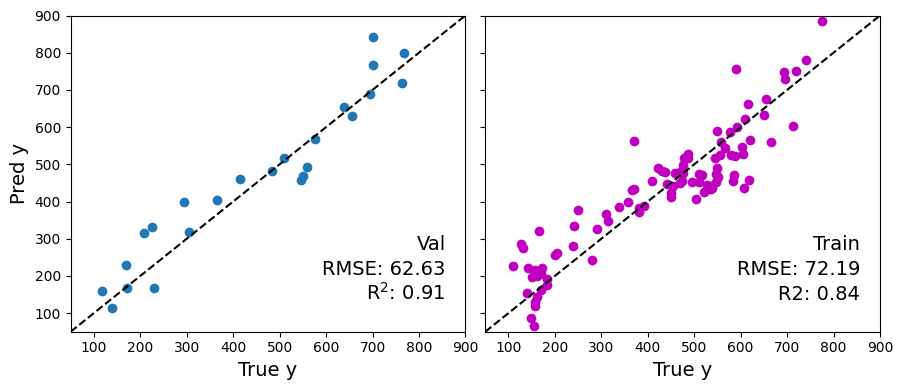

Root mean squared error: 62.63
Coefficient of determination: 0.91


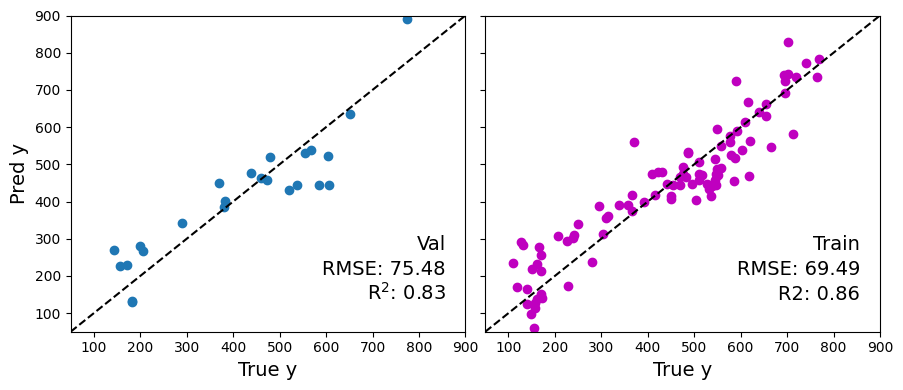

Root mean squared error: 75.48
Coefficient of determination: 0.83


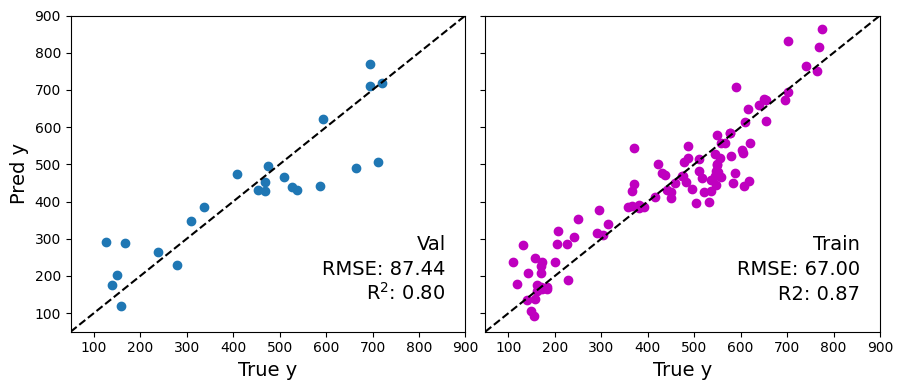

Root mean squared error: 87.44
Coefficient of determination: 0.80


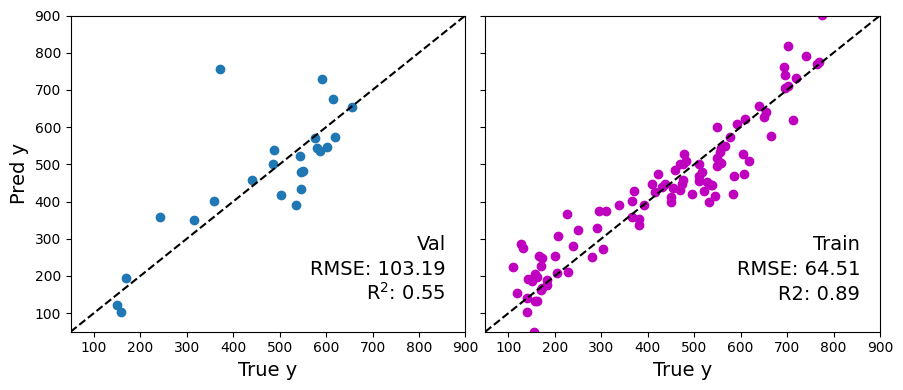

Root mean squared error: 103.19
Coefficient of determination: 0.55


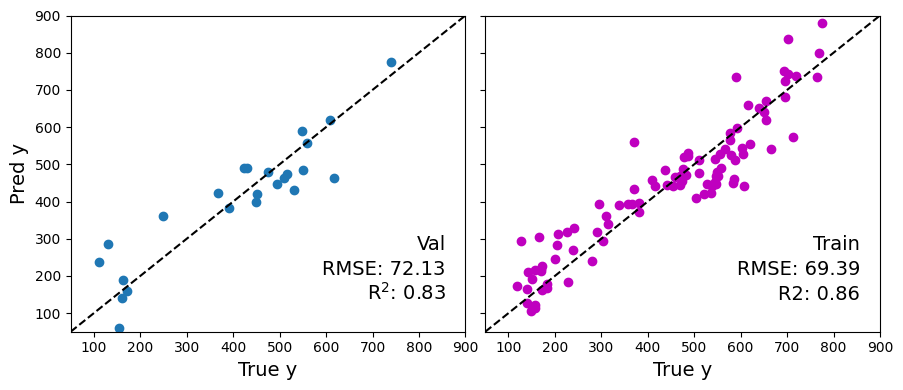

Root mean squared error: 72.13
Coefficient of determination: 0.83


In [194]:
kf = KFold(n_splits=5)

errors_pr = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors_pr.append(error)
errors_pr = pd.DataFrame(errors_pr)

In [195]:
errors_pr[['rmse_val','r2_val']].mean()

rmse_val    80.175233
r2_val       0.784219
dtype: float64

In [196]:
errors[['rmse_val','r2_val']].mean()

rmse_val    86.266692
r2_val       0.769193
dtype: float64

## Question
Q1. Why polynomial regression model has better accuracy than that of linear regression model?

* In many cases the data may not always be in a linear relationship to provide accurate output in case of polynomial regression it has more flexibility to fit to the given training dataset.
* As said polynomial regression would give a better fit than the linar regression but there is high possibility of overfitting in this case.

### Regularization

In [197]:
pr_l2 = Ridge(alpha=1)

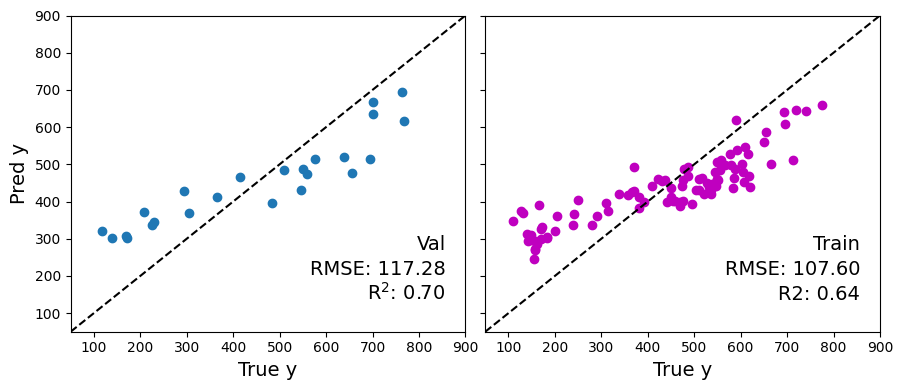

Mean squared error: 117.28
Coefficient of determination: 0.70


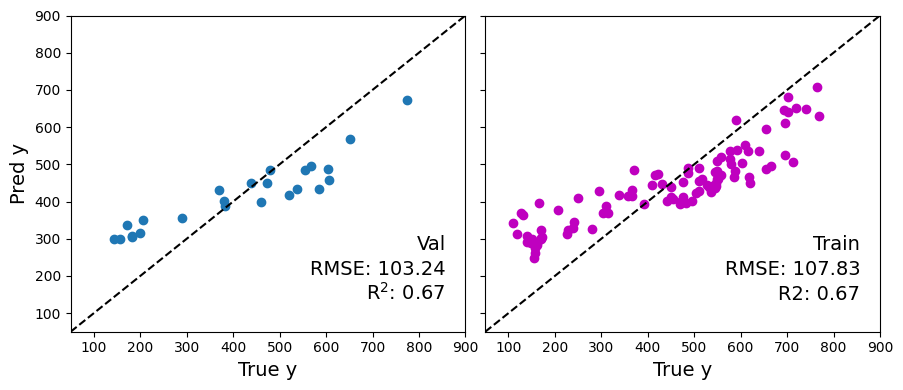

Mean squared error: 103.24
Coefficient of determination: 0.67


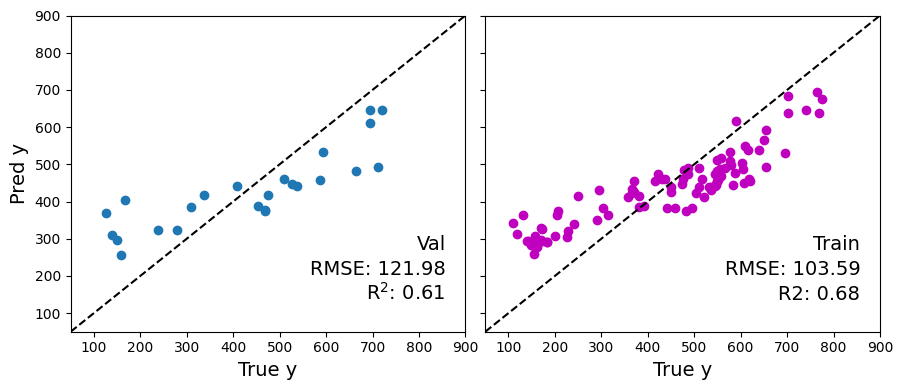

Mean squared error: 121.98
Coefficient of determination: 0.61


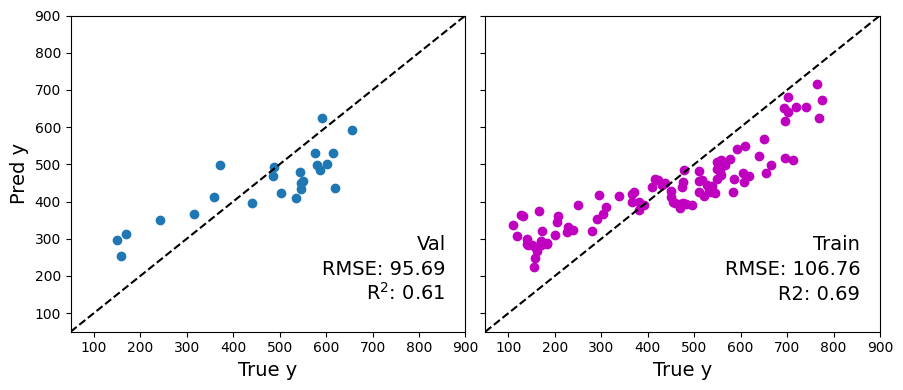

Mean squared error: 95.69
Coefficient of determination: 0.61


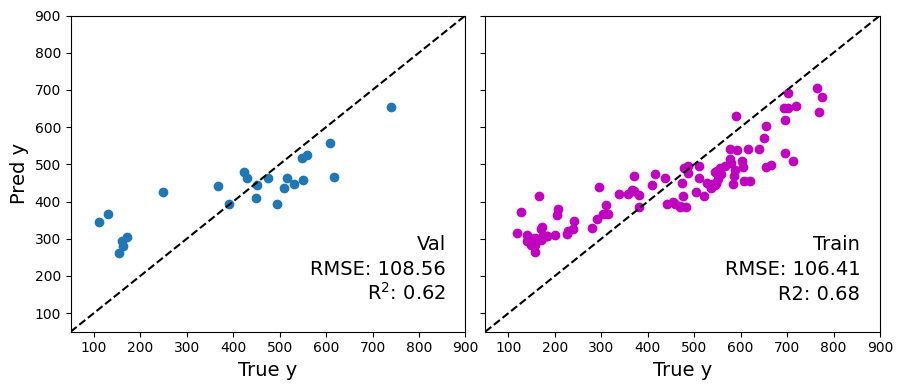

Mean squared error: 108.56
Coefficient of determination: 0.62


In [198]:
errors_pr_l2 = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = pr_l2.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_pr_l2.append(error)
errors_pr_l2 = pd.DataFrame(errors_pr_l2)

## Question
Q2. Regularization seems to decrease model accuracy. Can you spot someway of improving performance of the regularized model?

* We have kept the alpha parameter as 1, by tuning the hyperparameters we can increase the model accuracy.
* By trying out other type of regularization techniques.


### Regularization with coefficient optimization

In [199]:
c_values = [0.0001, 0.0005, 0.00065, 0.0008, 0.001, 0.0012, 0.0014, 0.002, 0.01, 0.05, 0.1, 1, 2]
hyper_params = {'alpha':c_values}

In [200]:
lr_ridge = Ridge()
clf = GridSearchCV(lr_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

In [201]:
_ = clf.fit(X,y)

rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([ 80.37746946,  78.74822196,  78.5320316 ,  78.40731424,
        78.33075385,  78.3187628 ,  78.34695547,  78.55197774,
        81.34239268,  84.25826775,  85.24084833, 109.75686778,
       129.52780229])

Text(0, 0.5, 'RMSE')

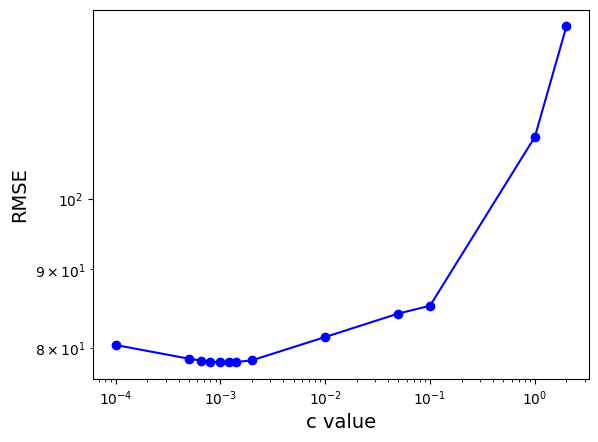

In [202]:
plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [203]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(0.0012, 78.31876280147227)

In [204]:
c_opt = c_values[min_idx]

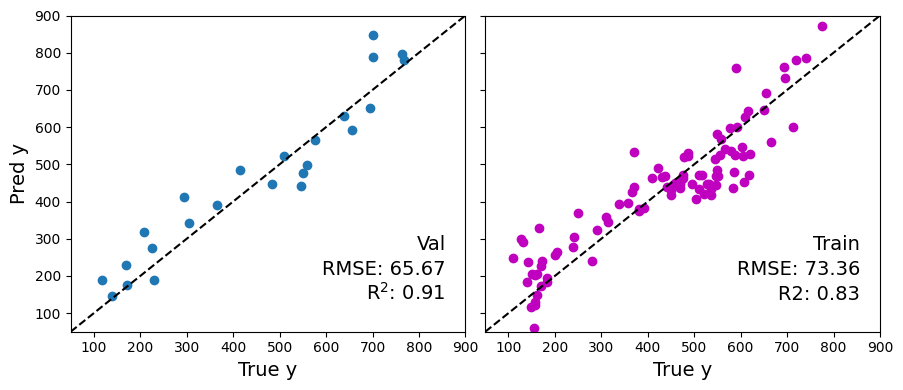

Root Mean squared error: 65.67
Coefficient of determination: 0.91


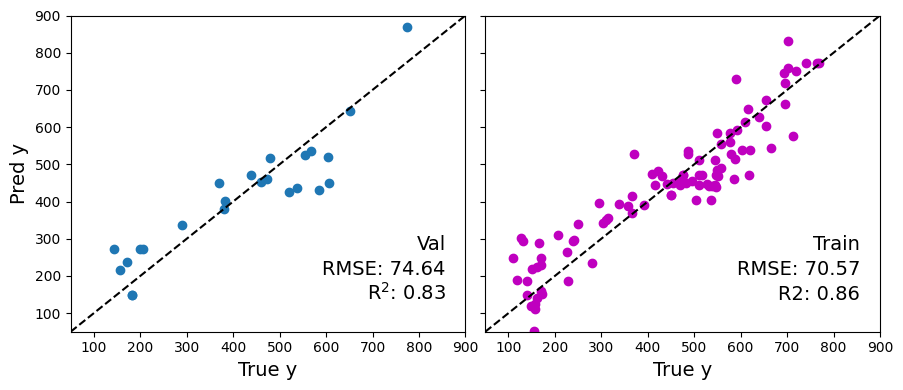

Root Mean squared error: 74.64
Coefficient of determination: 0.83


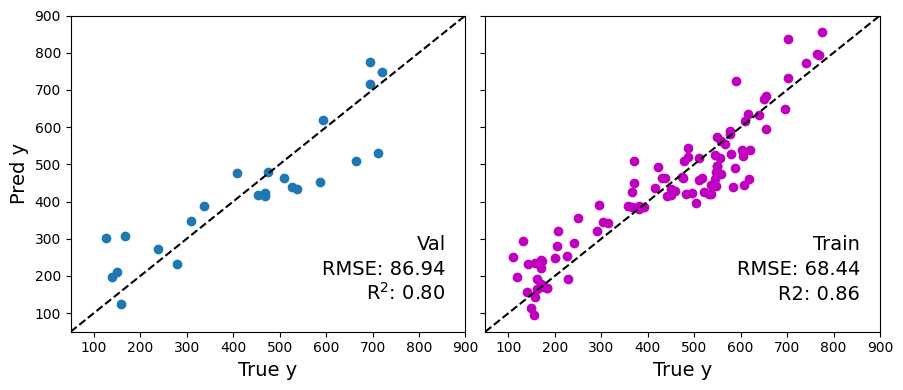

Root Mean squared error: 86.94
Coefficient of determination: 0.80


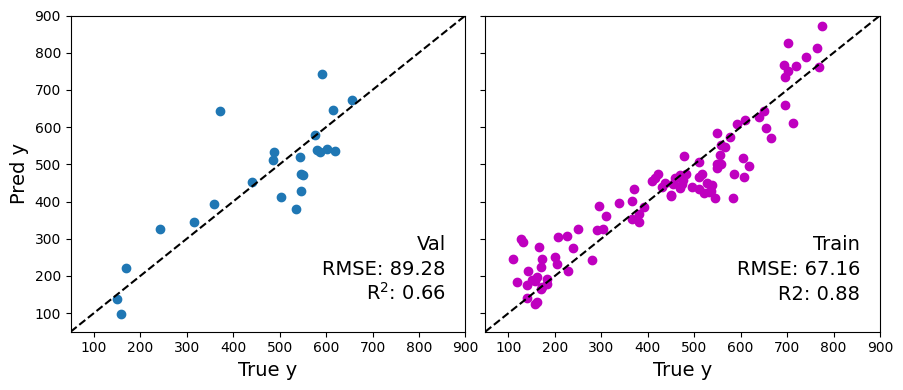

Root Mean squared error: 89.28
Coefficient of determination: 0.66


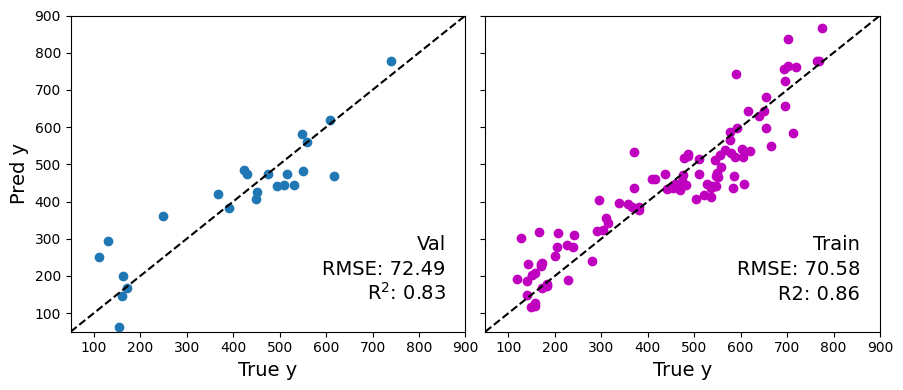

Root Mean squared error: 72.49
Coefficient of determination: 0.83


In [205]:
pr_ridge_c_opt = Ridge(alpha=c_opt)

errors_l2_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = pr_ridge_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_l2_c_opt.append(error)
errors_l2_c_opt = pd.DataFrame(errors_l2_c_opt)

In [206]:
errors_l2_c_opt[['rmse_val','r2_val']].mean()

rmse_val    77.805559
r2_val       0.806103
dtype: float64

## Question
Q3. Try making new polynomial type features to improve polynomial regression model accuracy. Explain why addition of new features could improve model performance.

In [301]:
assign_new_data = data.copy()

In [302]:
cols = [1,2]
powers = [2,2]
assign_new_data = make_new_feature(assign_new_data, cols, powers, 'n.1')

cols = [5]
powers = [3]
assign_new_data = make_new_feature(assign_new_data, cols, powers, 'n.2')

cols = [0,1,2]
powers = [1,1,1]
assign_new_data = make_new_feature(assign_new_data, cols, powers, 'n.3')

cols = [1,2, 3]
powers = [1,1,1]
assign_new_data = make_new_feature(assign_new_data, cols, powers, 'n.4')

In [303]:
assign_new_data.head()

ID   HV      C.al      C.co      C.cr      C.cu      C.fe      C.ni  \
0    7  139  0.000000  0.250000  0.250000  0.000000  0.250000  0.250000   
1   48  295  0.153846  0.307692  0.153846  0.076923  0.153846  0.153846   
2  108  545  0.222222  0.111111  0.000000  0.222222  0.222222  0.222222   
3  146  701  0.428571  0.214286  0.071429  0.071429  0.071429  0.142857   
4   37  207  0.090909  0.181818  0.181818  0.181818  0.181818  0.181818   

        n.1       n.2       n.3       n.4  
0  0.003906  0.015625  0.000000  0.000000  
1  0.002241  0.003641  0.007283  0.003641  
2  0.000000  0.010974  0.000000  0.000000  
3  0.000234  0.002915  0.006560  0.001093  
4  0.001093  0.006011  0.003005  0.006011

In [304]:
assign_Xcols = assign_new_data.columns[assign_new_data.columns.str.contains("C.") | assign_new_data.columns.str.contains("n.")]
assign_X = assign_new_data[assign_Xcols]
assign_X

C.al      C.co      C.cr      C.cu      C.fe      C.ni       n.1  \
0    0.000000  0.250000  0.250000  0.000000  0.250000  0.250000  0.003906   
1    0.153846  0.307692  0.153846  0.076923  0.153846  0.153846  0.002241   
2    0.222222  0.111111  0.000000  0.222222  0.222222  0.222222  0.000000   
3    0.428571  0.214286  0.071429  0.071429  0.071429  0.142857  0.000234   
4    0.090909  0.181818  0.181818  0.181818  0.181818  0.181818  0.001093   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667  0.000000   
116  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059  0.000000   
117  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667  0.001736   
118  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667  0.003086   
119  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575  0.002042   

          n.2       n.3       n.4  
0    0.015625  0.000000  0.000000  
1    0.003641  0.007283  0.003641  
2    0.010974  0.000000  0.000000  
3    0.002915  0.006560  0.001093  
4    0.006011  0.003005  0.006011  
..        ...       ...       ...  
115  0.004630  0.000000  0.000000  
116  0.003180  0.000000  0.000000  
117  0.004630  0.006944  0.003472  
118  0.004630  0.009259  0.000000  
119  0.009606  0.000000  0.009606  

[120 rows x 10 columns]

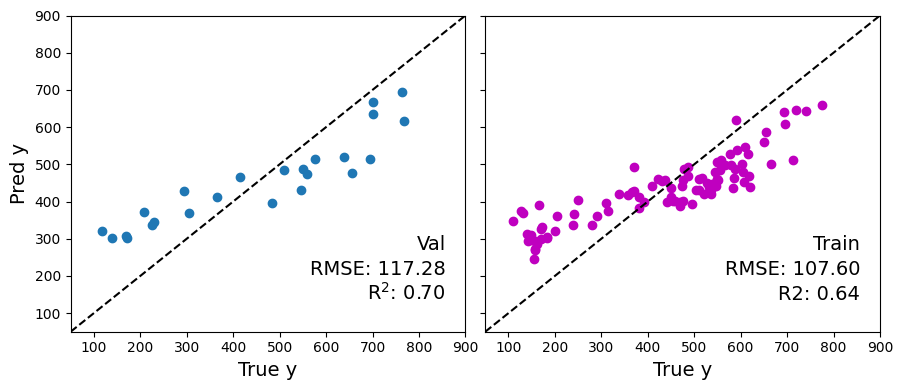

Mean squared error: 117.28
Coefficient of determination: 0.70


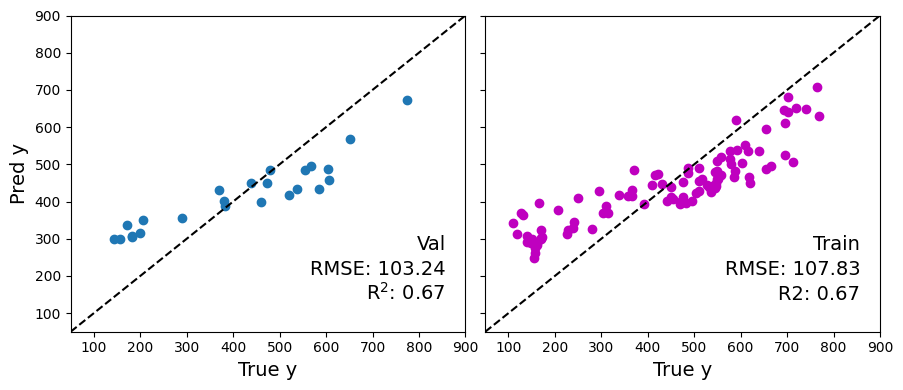

Mean squared error: 103.24
Coefficient of determination: 0.67


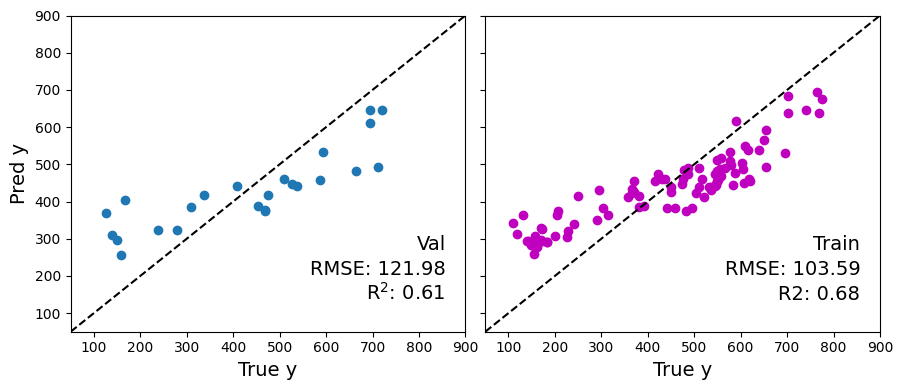

Mean squared error: 121.98
Coefficient of determination: 0.61


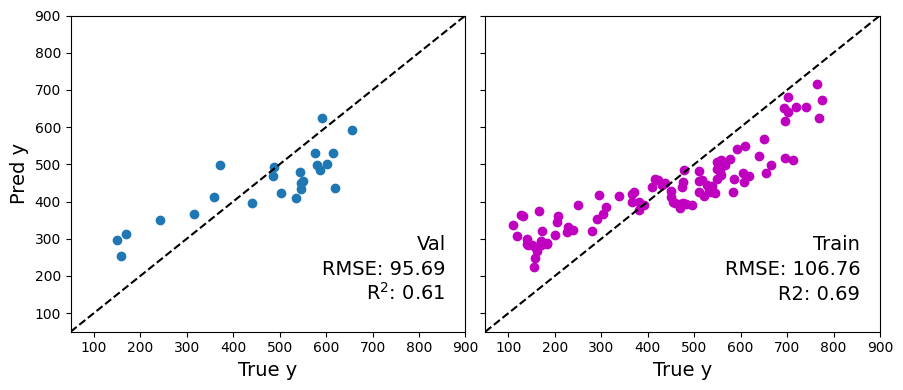

Mean squared error: 95.69
Coefficient of determination: 0.61


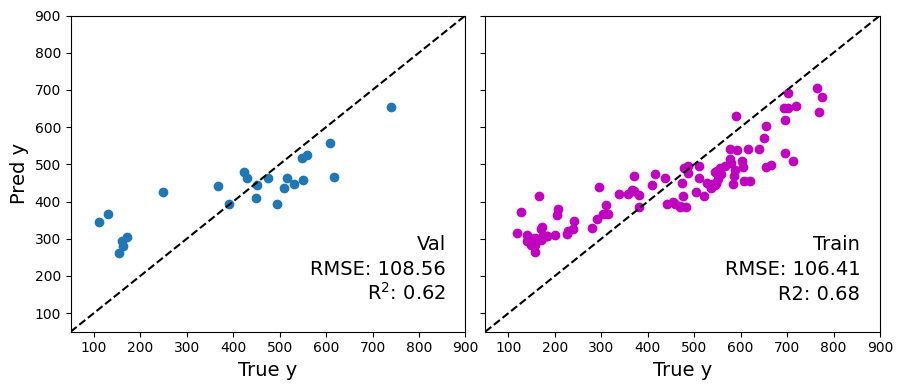

Mean squared error: 108.56
Coefficient of determination: 0.62


In [305]:
pr_l2 = Ridge(alpha=1)

assign_errors_pr_l2 = []

for idx, (train, val) in enumerate(kf.split(assign_X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = pr_l2.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    assign_errors_pr_l2.append(error)
assign_errors_pr_l2 = pd.DataFrame(assign_errors_pr_l2)

In [306]:
c_values = [0.000001,0.0001, 0.01, 0.05, 0.08,0.09, 0.1]
hyper_params = {'alpha':c_values}

In [307]:
lr_ridge = Ridge()
clf = GridSearchCV(lr_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

In [308]:
_ = clf.fit(assign_X,y)

rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([77.56930451, 78.20536766, 86.00784116, 86.41558364, 86.58196462,
       86.66460837, 86.76106784])

Text(0, 0.5, 'RMSE')

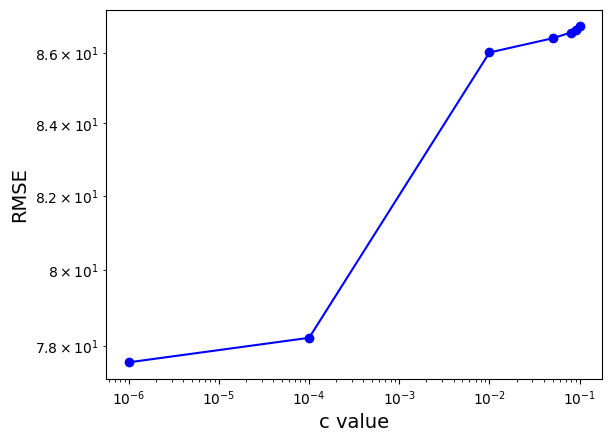

In [309]:

plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [310]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(1e-06, 77.56930451134544)

In [311]:
c_opt = c_values[min_idx]

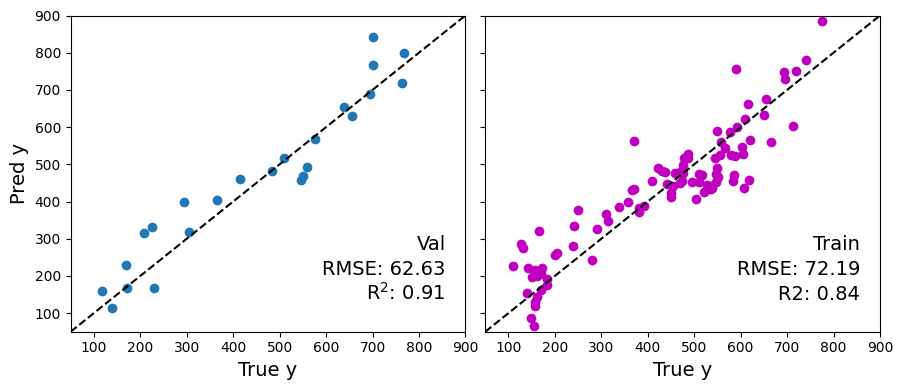

Root Mean squared error: 62.63
Coefficient of determination: 0.91


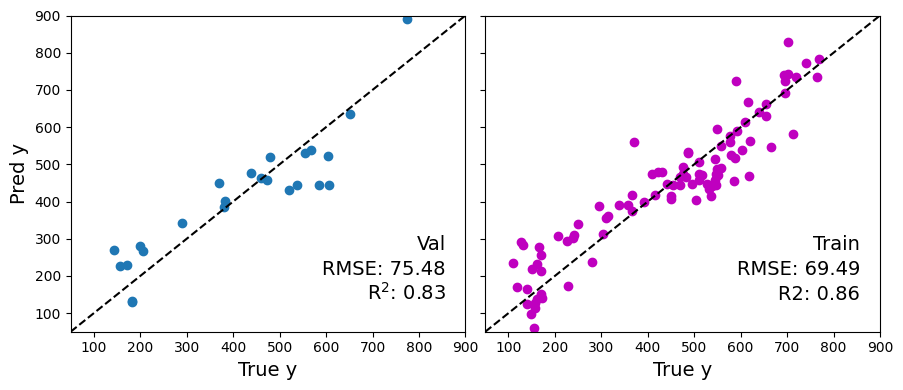

Root Mean squared error: 75.48
Coefficient of determination: 0.83


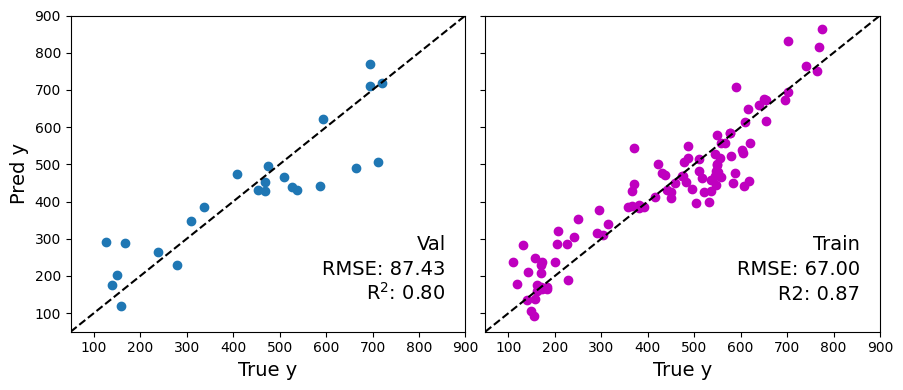

Root Mean squared error: 87.43
Coefficient of determination: 0.80


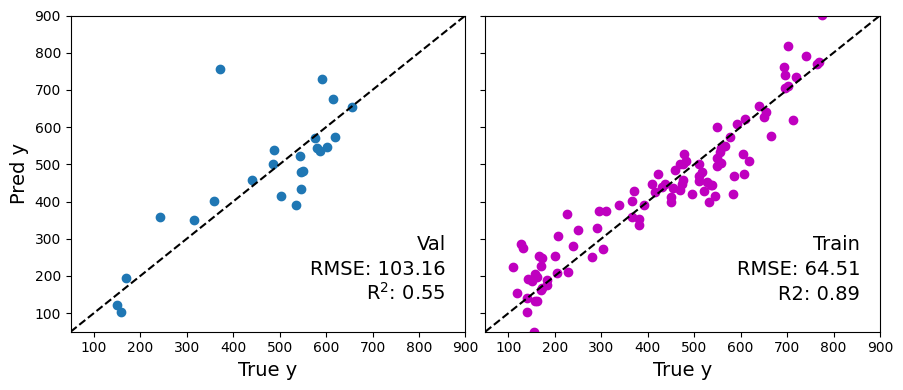

Root Mean squared error: 103.16
Coefficient of determination: 0.55


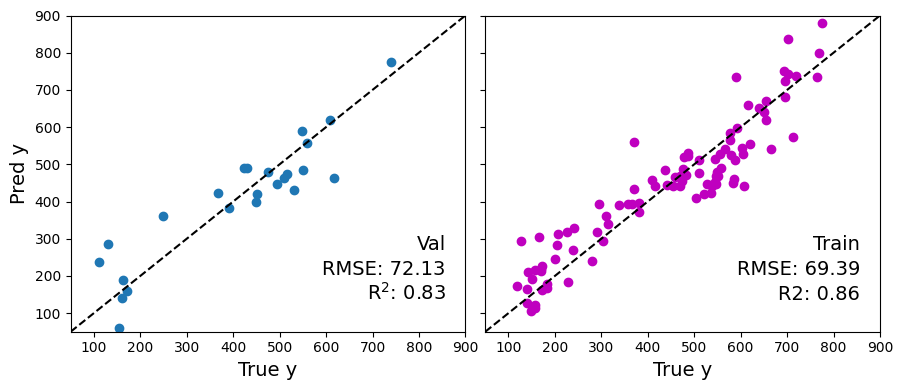

Root Mean squared error: 72.13
Coefficient of determination: 0.83


In [312]:
pr_ridge_c_opt = Ridge(alpha=c_opt)

errors_l2_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = pr_ridge_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_l2_c_opt.append(error)
errors_l2_c_opt = pd.DataFrame(errors_l2_c_opt)

In [313]:
errors_l2_c_opt[['rmse_val','r2_val']].mean()

rmse_val    80.164457
r2_val       0.784298
dtype: float64

* By creating new features using mixed relationship of the provided dataset we increase the complexity of the model which helps it to generalise more compared with previous dataset.
* In polynomial regression the relationship between the features and the target is not linear as the created new features there is better way to generalise the model.
* It avoids both underfitting as well as overfitting of the model. It prevents underfitting as there are more features to analyse and as we are doing regularization it prevents overfitting.

# Tutorial 4 starts here

### Normalization

In [220]:
scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))

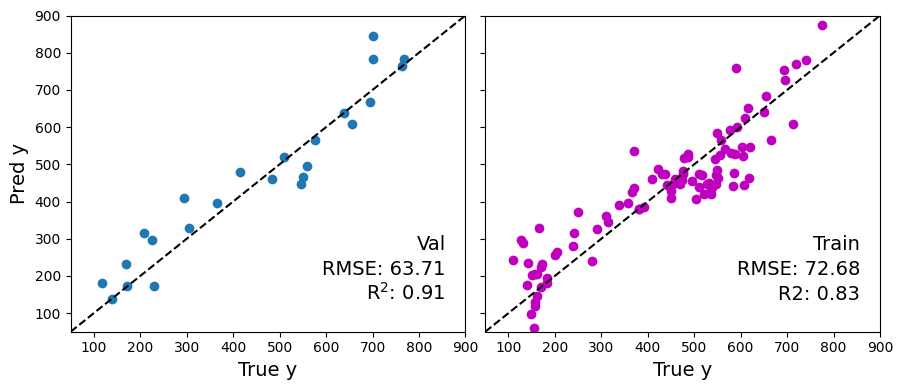

Root Mean squared error: 63.71
Coefficient of determination: 0.91


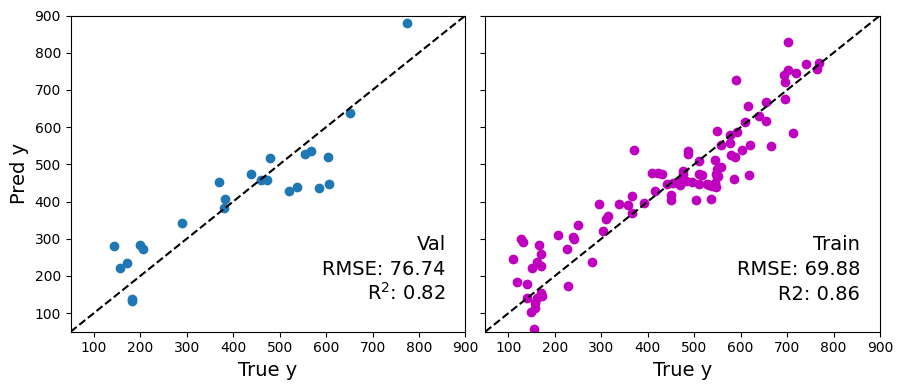

Root Mean squared error: 76.74
Coefficient of determination: 0.82


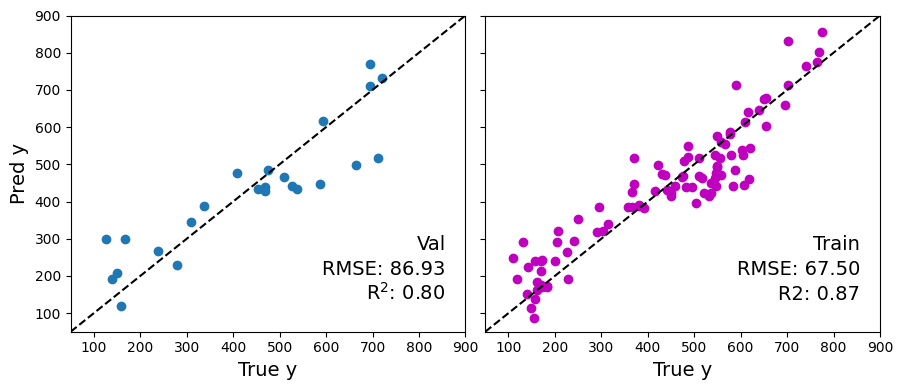

Root Mean squared error: 86.93
Coefficient of determination: 0.80


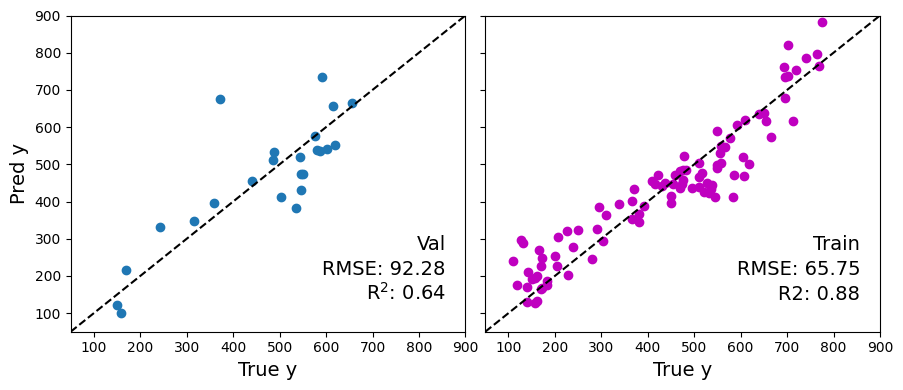

Root Mean squared error: 92.28
Coefficient of determination: 0.64


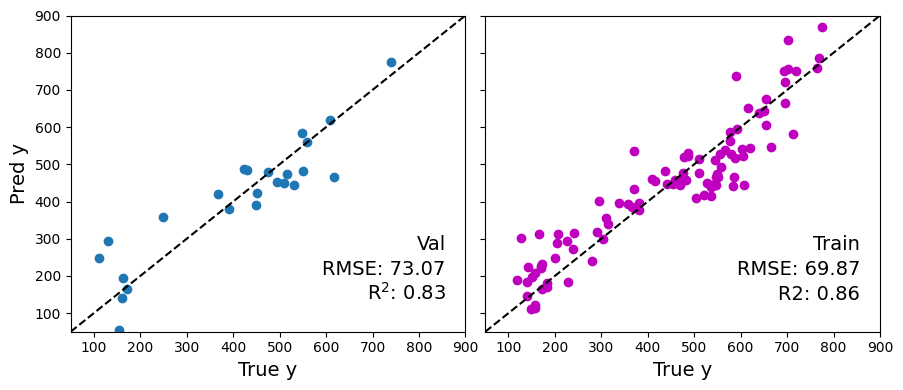

Root Mean squared error: 73.07
Coefficient of determination: 0.83


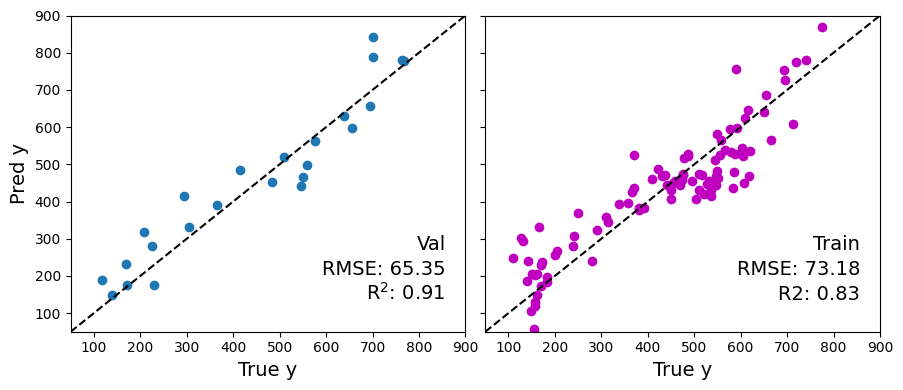

Root Mean squared error: 65.35
Coefficient of determination: 0.91


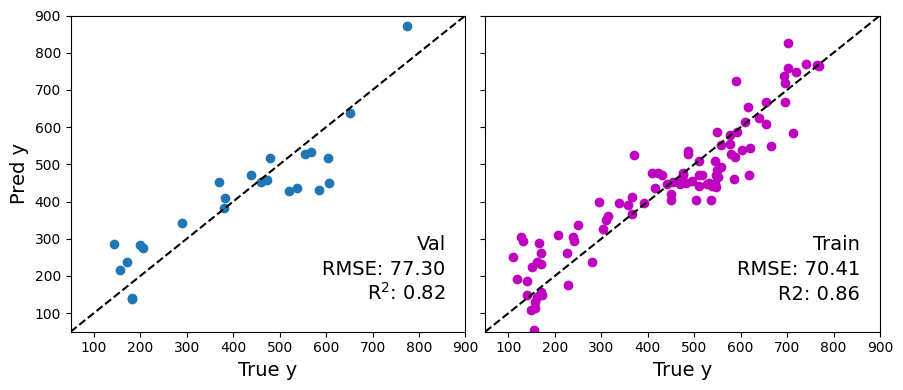

Root Mean squared error: 77.30
Coefficient of determination: 0.82


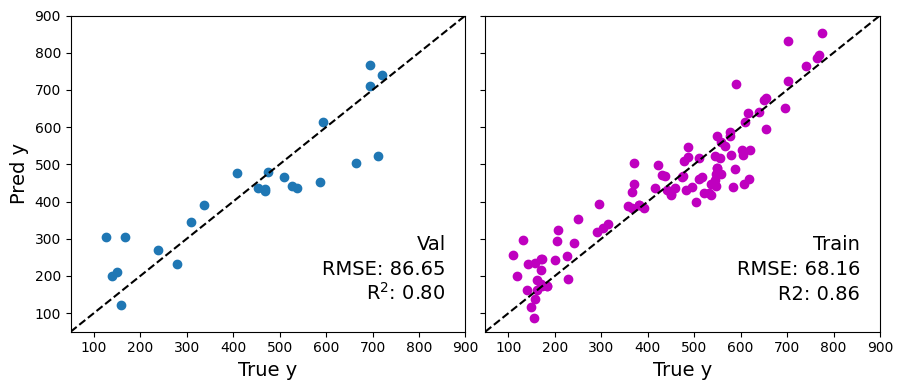

Root Mean squared error: 86.65
Coefficient of determination: 0.80


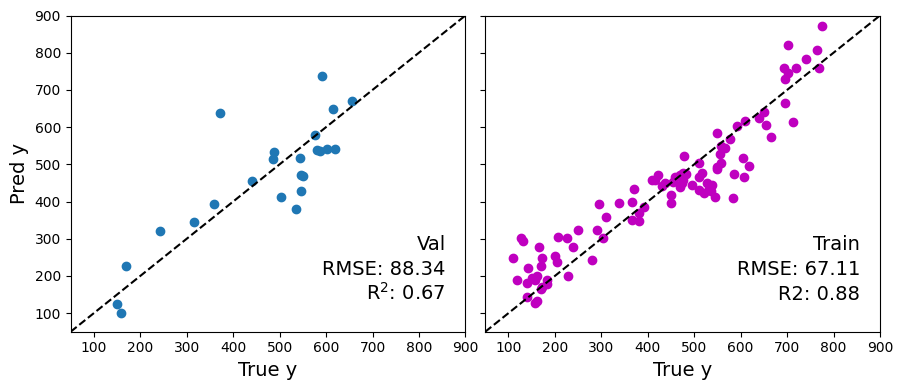

Root Mean squared error: 88.34
Coefficient of determination: 0.67


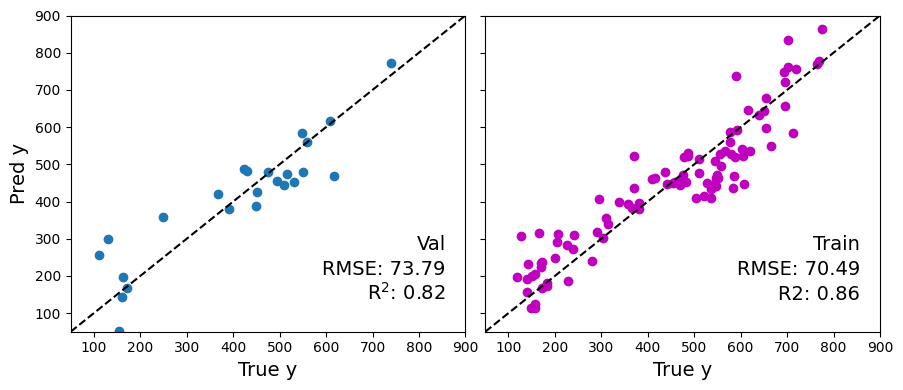

Root Mean squared error: 73.79
Coefficient of determination: 0.82


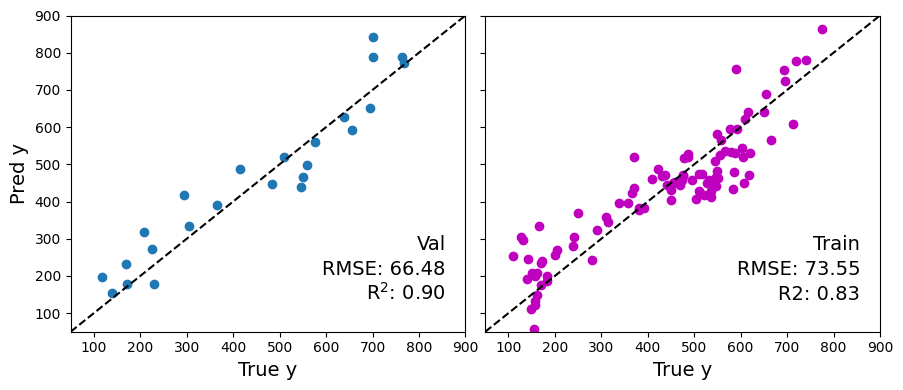

Root Mean squared error: 66.48
Coefficient of determination: 0.90


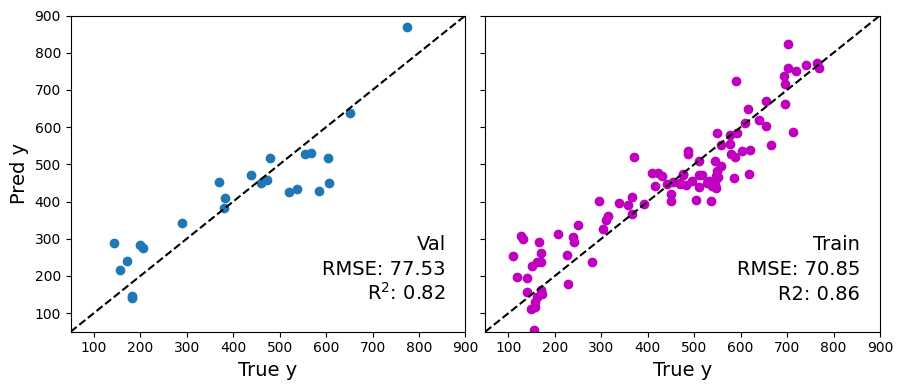

Root Mean squared error: 77.53
Coefficient of determination: 0.82


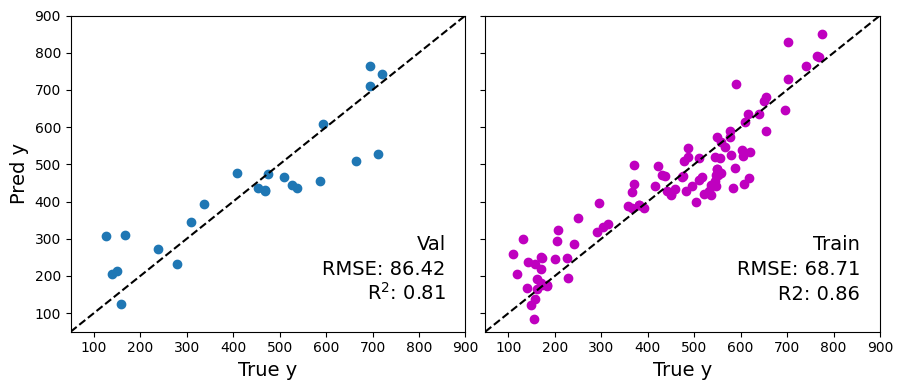

Root Mean squared error: 86.42
Coefficient of determination: 0.81


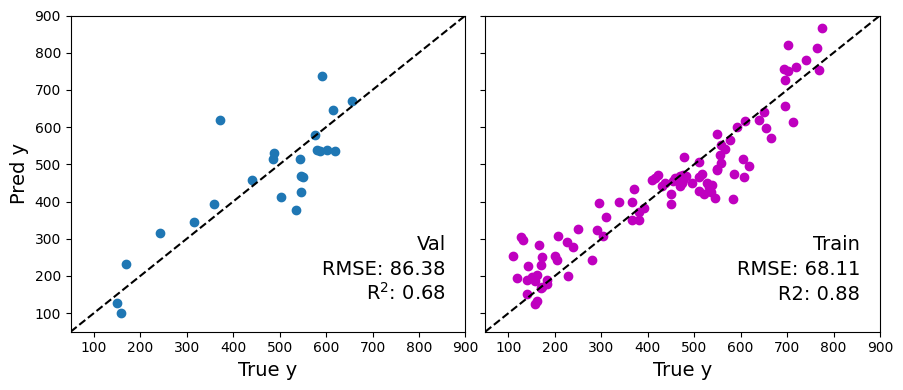

Root Mean squared error: 86.38
Coefficient of determination: 0.68


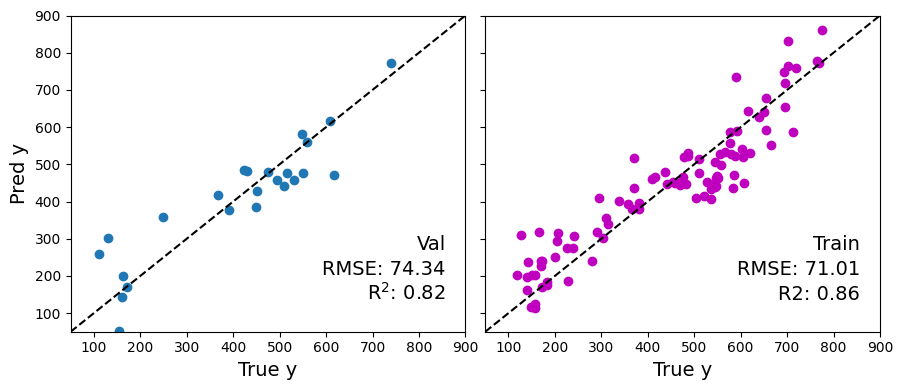

Root Mean squared error: 74.34
Coefficient of determination: 0.82


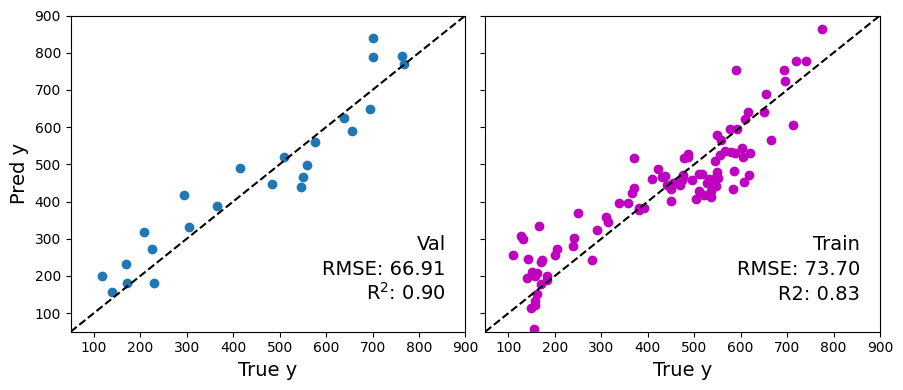

Root Mean squared error: 66.91
Coefficient of determination: 0.90


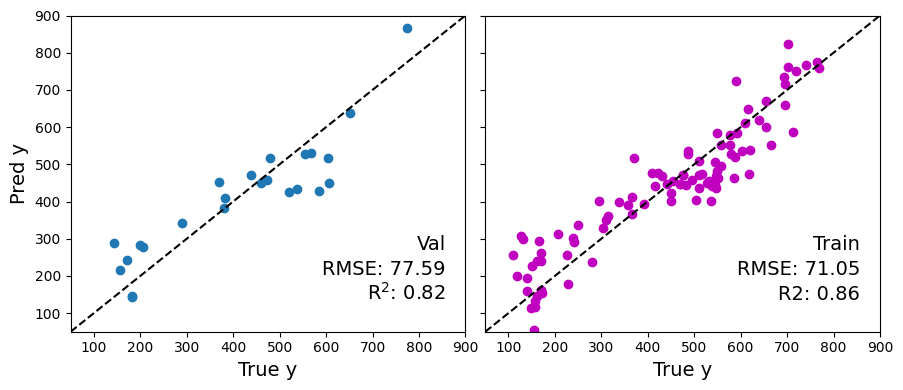

Root Mean squared error: 77.59
Coefficient of determination: 0.82


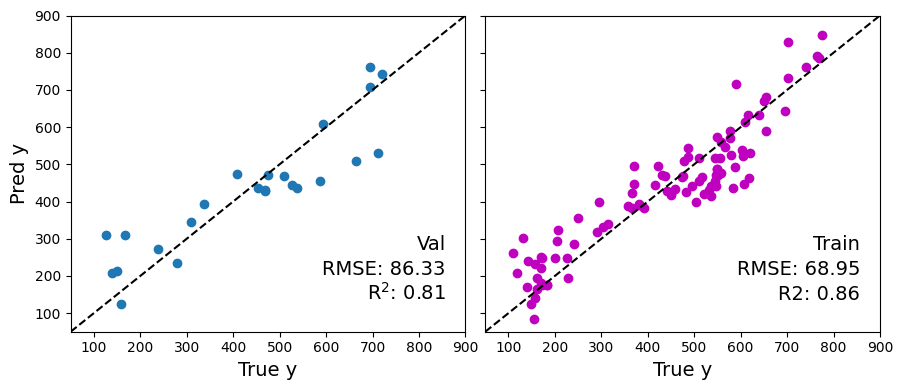

Root Mean squared error: 86.33
Coefficient of determination: 0.81


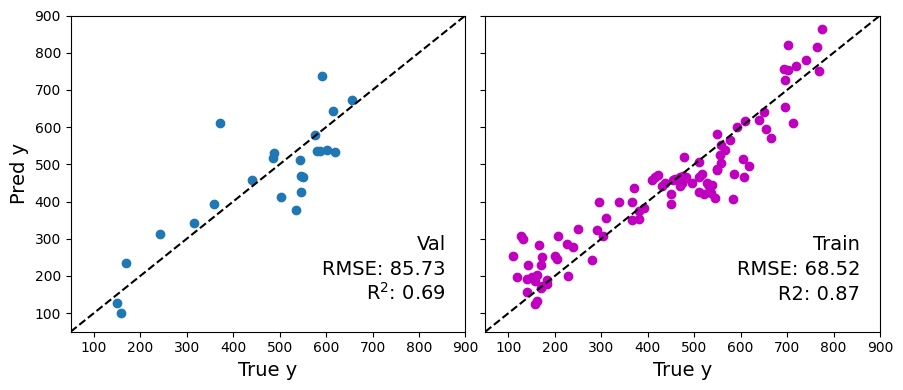

Root Mean squared error: 85.73
Coefficient of determination: 0.69


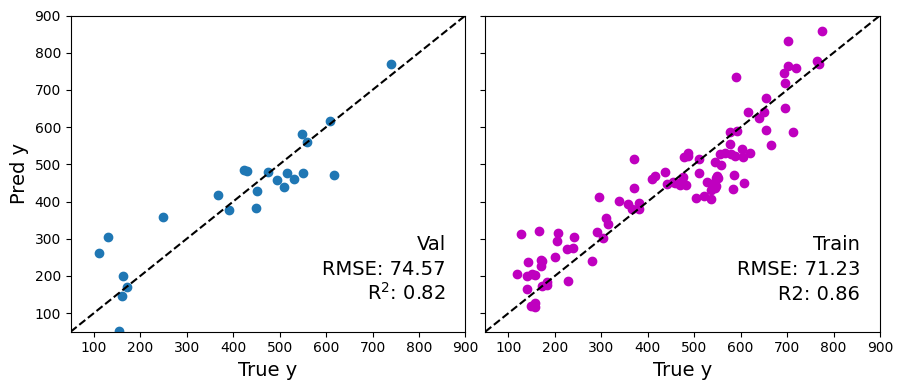

Root Mean squared error: 74.57
Coefficient of determination: 0.82


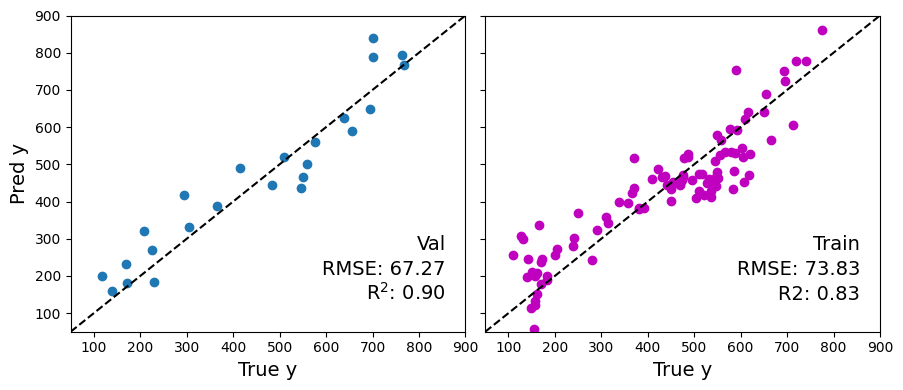

Root Mean squared error: 67.27
Coefficient of determination: 0.90


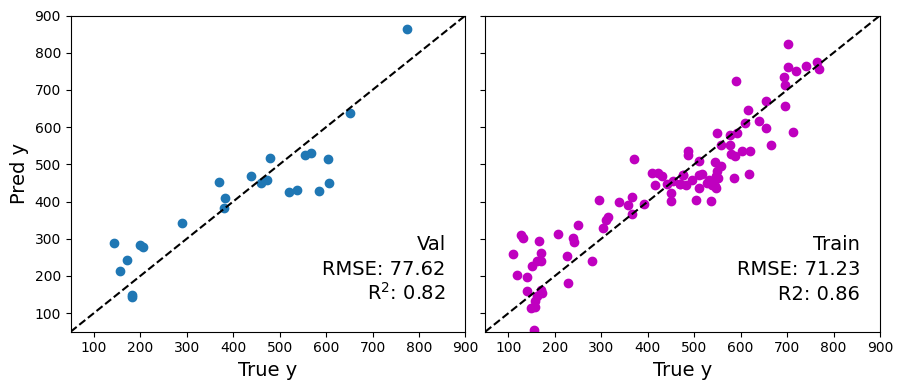

Root Mean squared error: 77.62
Coefficient of determination: 0.82


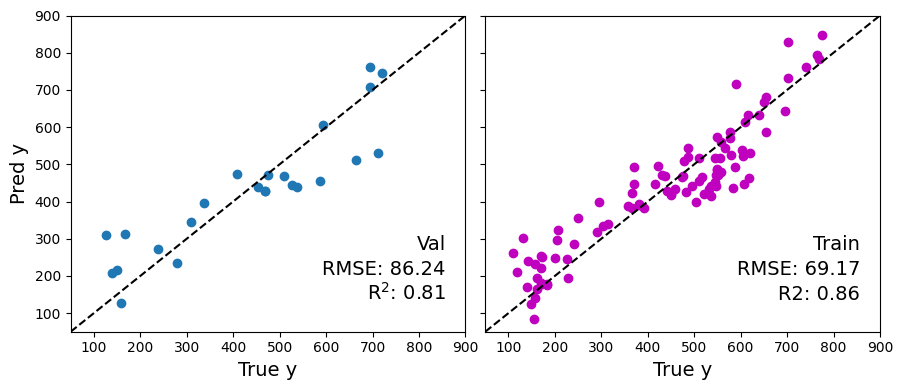

Root Mean squared error: 86.24
Coefficient of determination: 0.81


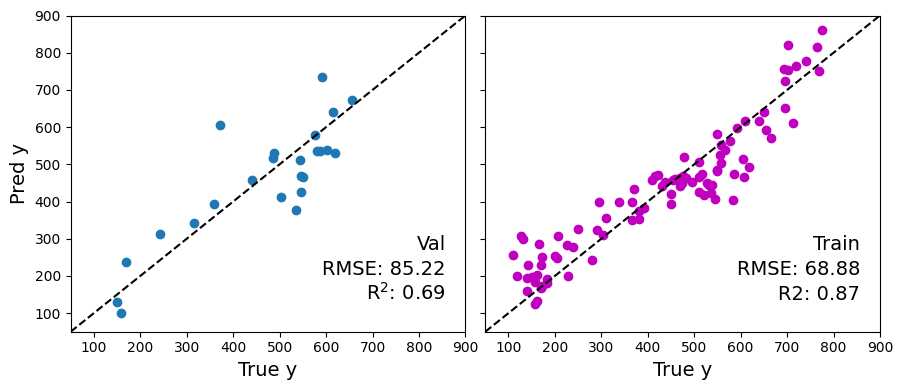

Root Mean squared error: 85.22
Coefficient of determination: 0.69


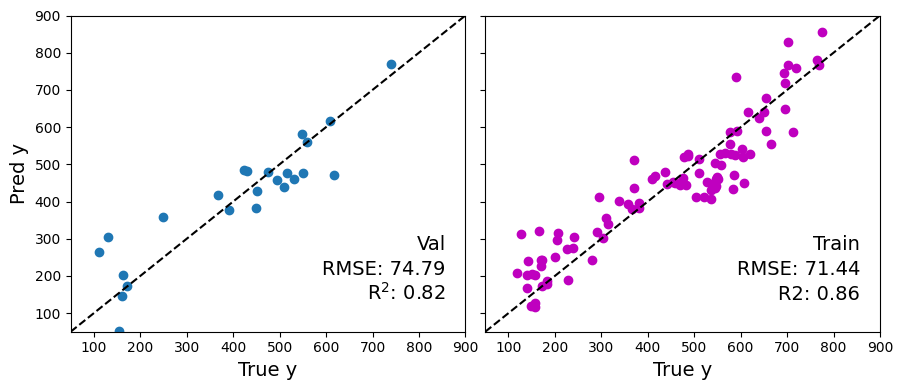

Root Mean squared error: 74.79
Coefficient of determination: 0.82


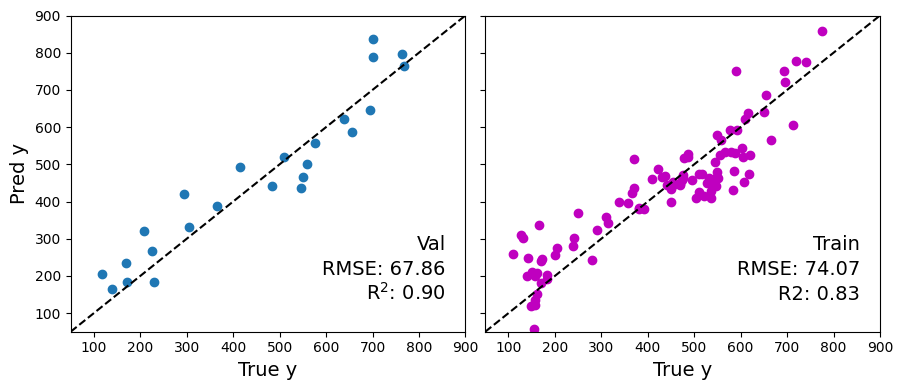

Root Mean squared error: 67.86
Coefficient of determination: 0.90


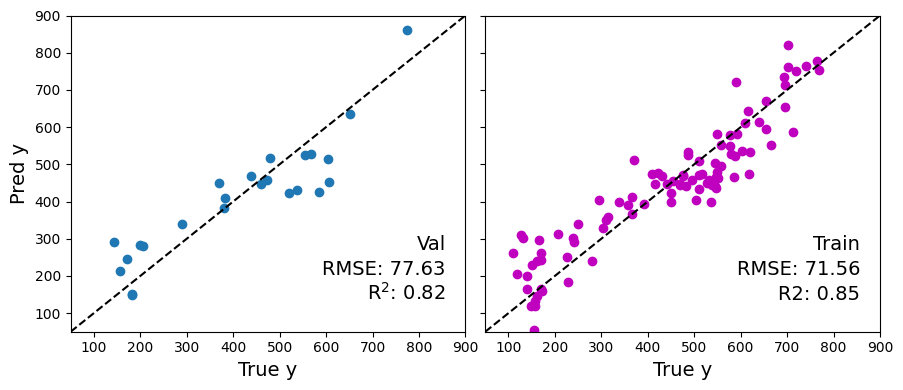

Root Mean squared error: 77.63
Coefficient of determination: 0.82


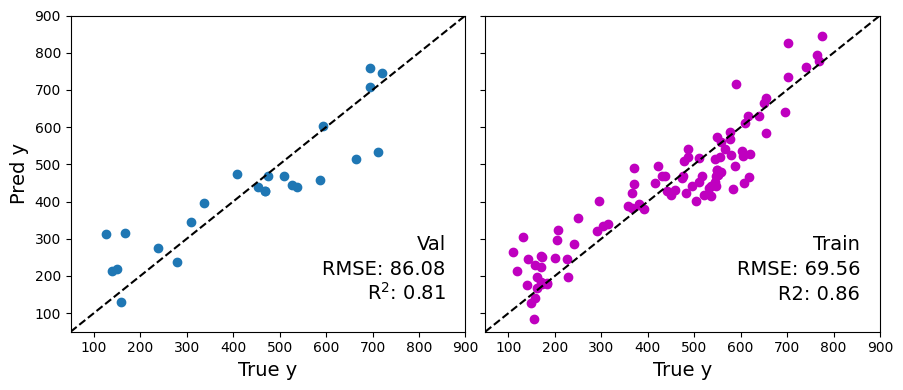

Root Mean squared error: 86.08
Coefficient of determination: 0.81


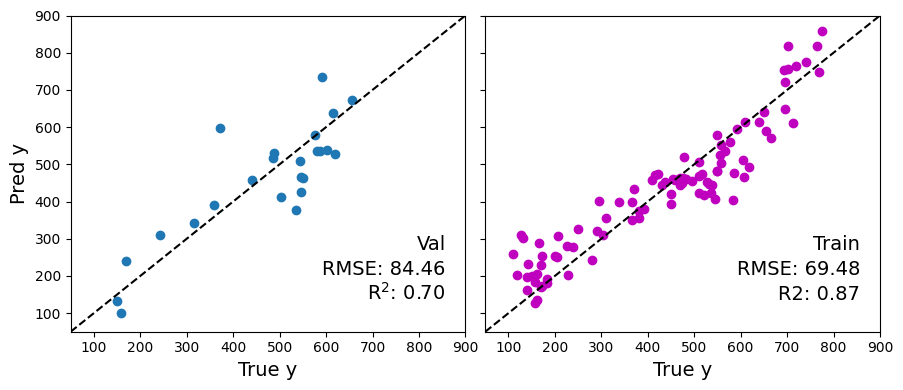

Root Mean squared error: 84.46
Coefficient of determination: 0.70


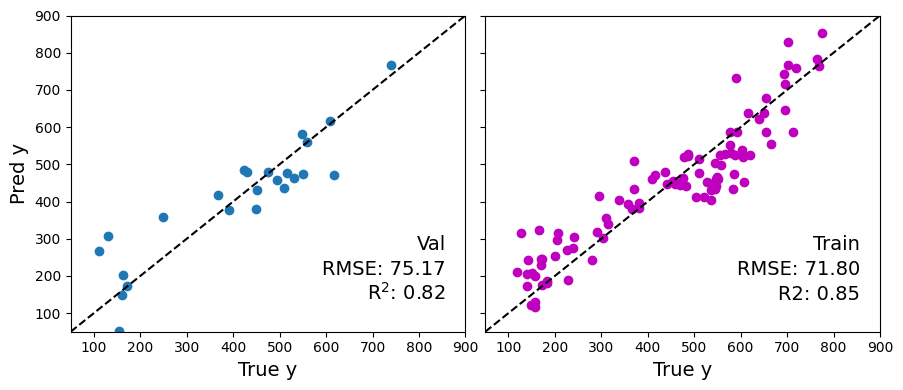

Root Mean squared error: 75.17
Coefficient of determination: 0.82


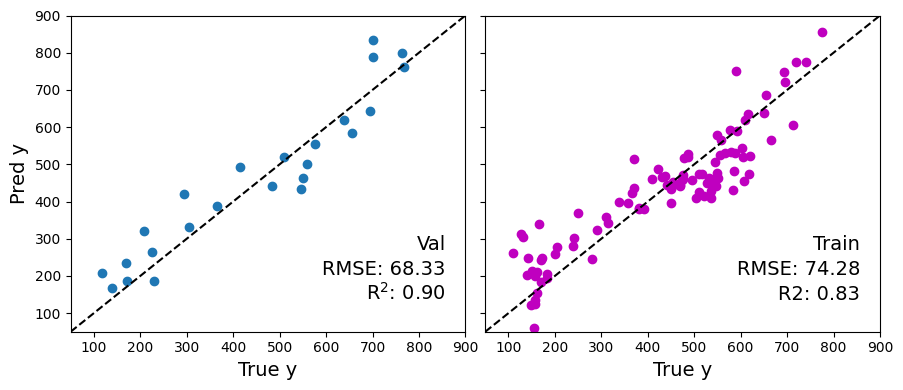

Root Mean squared error: 68.33
Coefficient of determination: 0.90


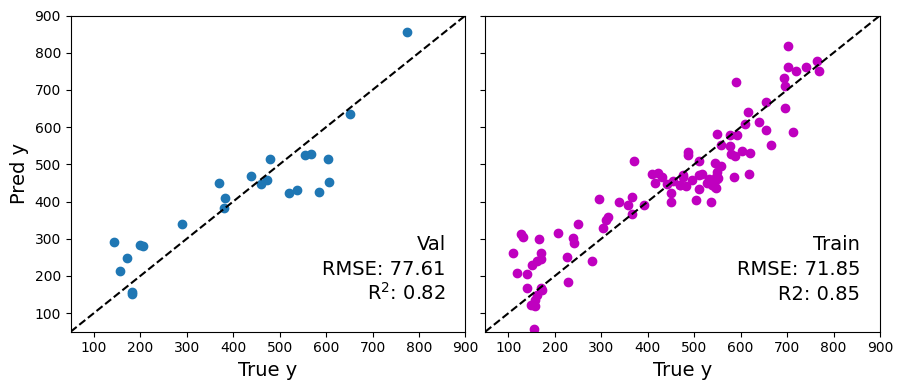

Root Mean squared error: 77.61
Coefficient of determination: 0.82


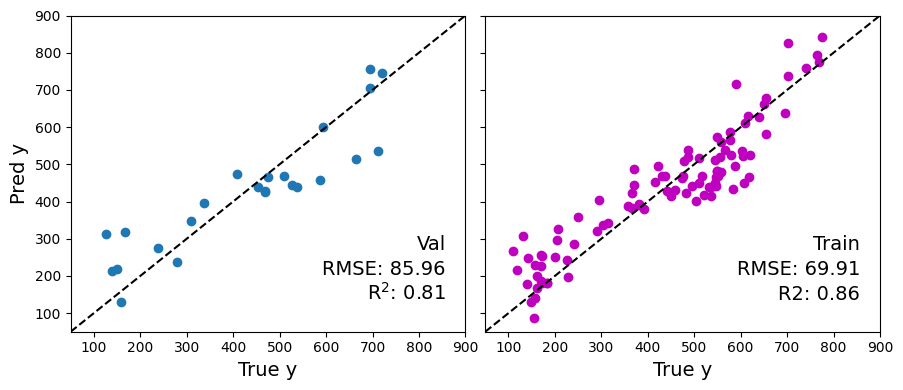

Root Mean squared error: 85.96
Coefficient of determination: 0.81


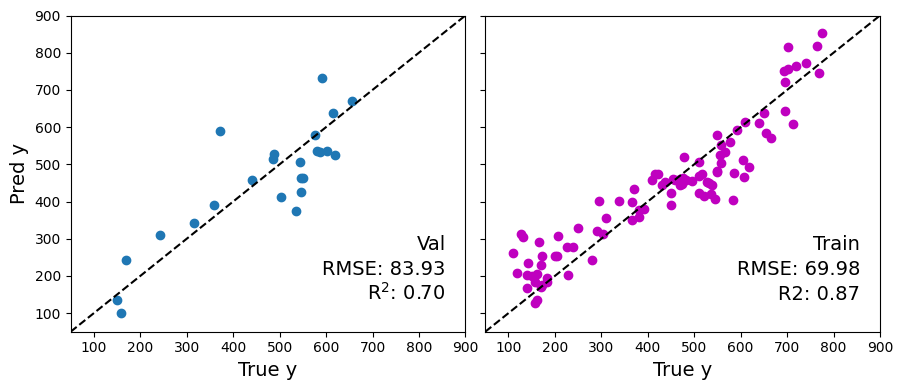

Root Mean squared error: 83.93
Coefficient of determination: 0.70


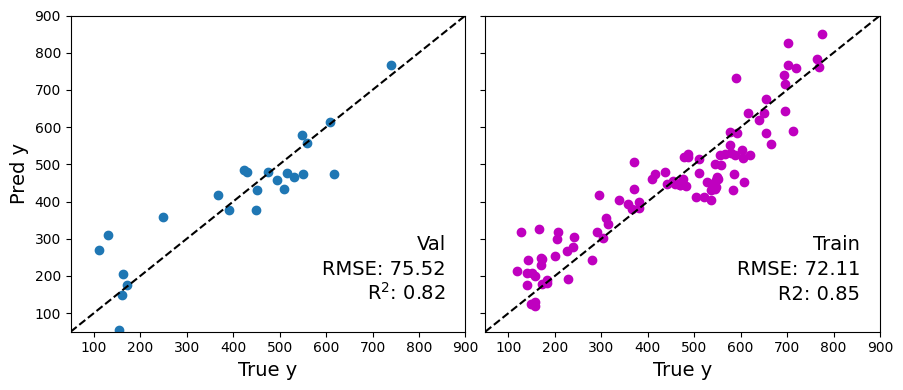

Root Mean squared error: 75.52
Coefficient of determination: 0.82


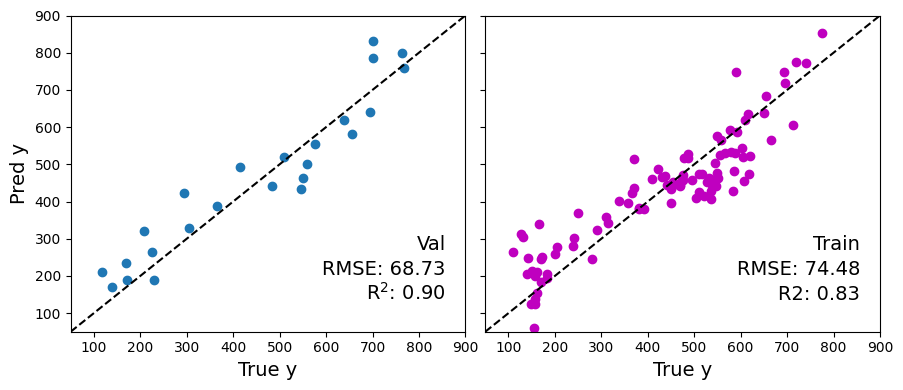

Root Mean squared error: 68.73
Coefficient of determination: 0.90


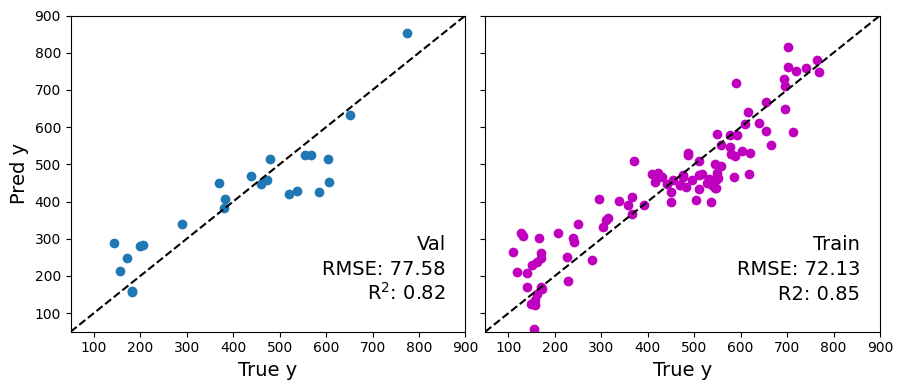

Root Mean squared error: 77.58
Coefficient of determination: 0.82


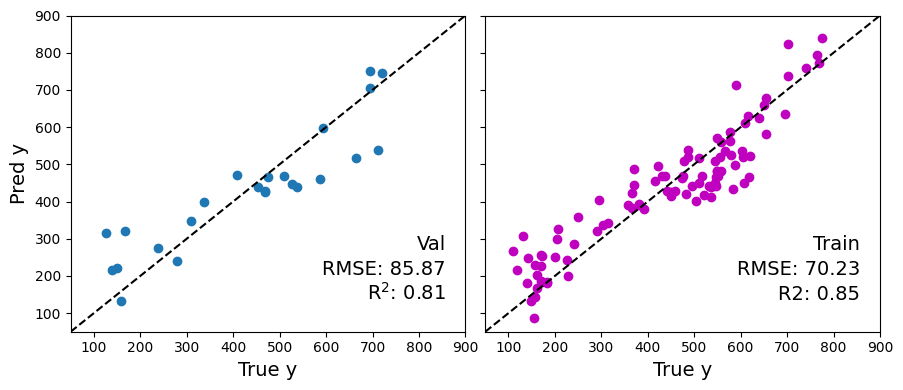

Root Mean squared error: 85.87
Coefficient of determination: 0.81


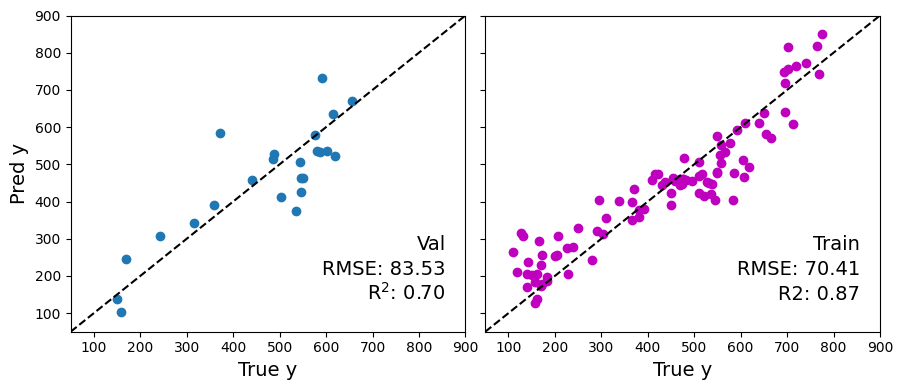

Root Mean squared error: 83.53
Coefficient of determination: 0.70


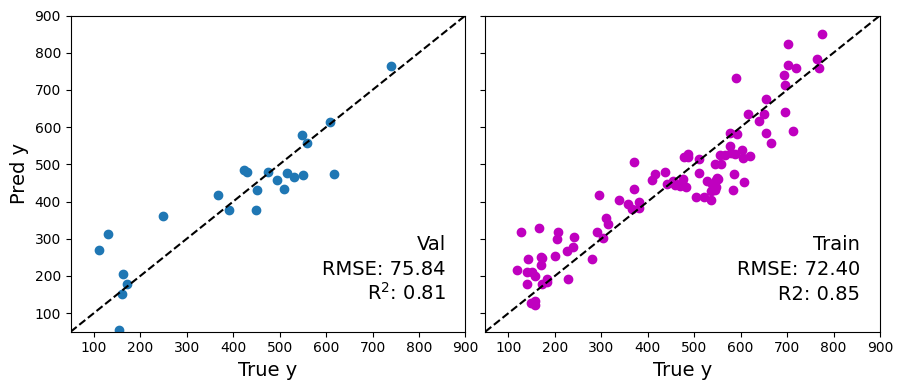

Root Mean squared error: 75.84
Coefficient of determination: 0.81


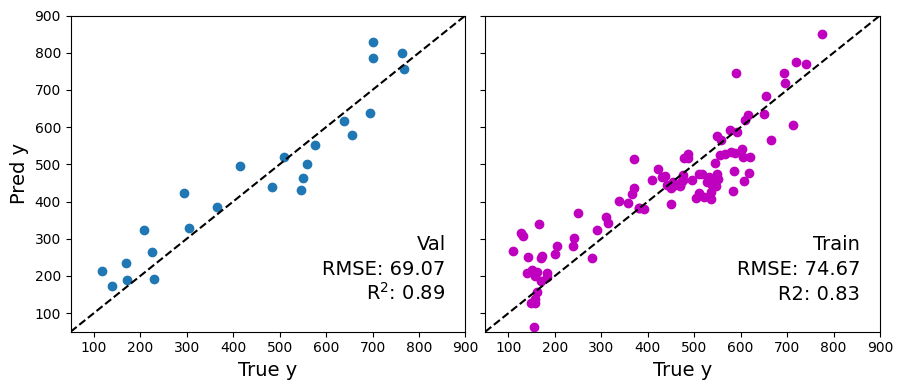

Root Mean squared error: 69.07
Coefficient of determination: 0.89


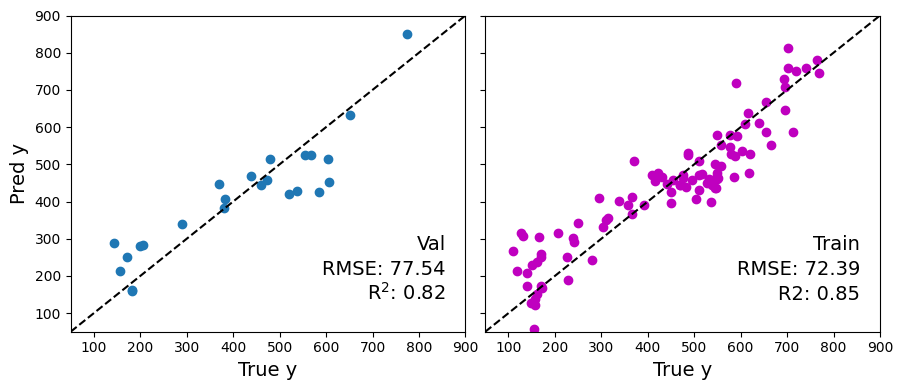

Root Mean squared error: 77.54
Coefficient of determination: 0.82


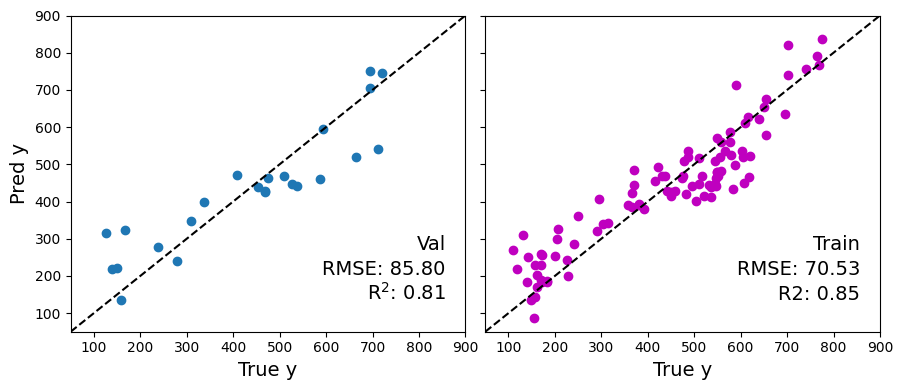

Root Mean squared error: 85.80
Coefficient of determination: 0.81


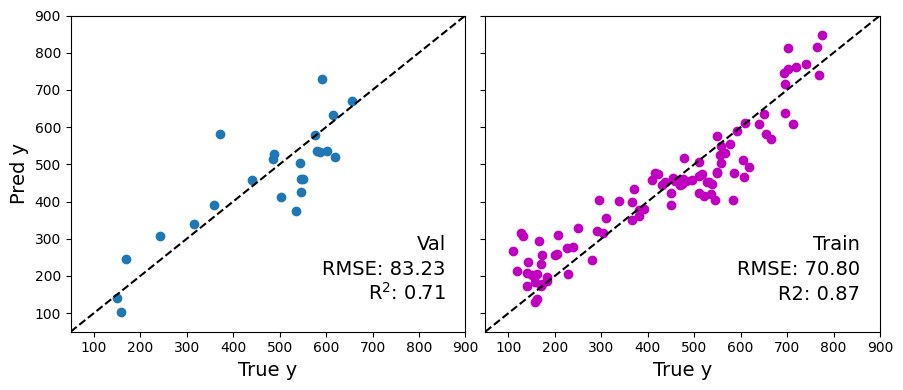

Root Mean squared error: 83.23
Coefficient of determination: 0.71


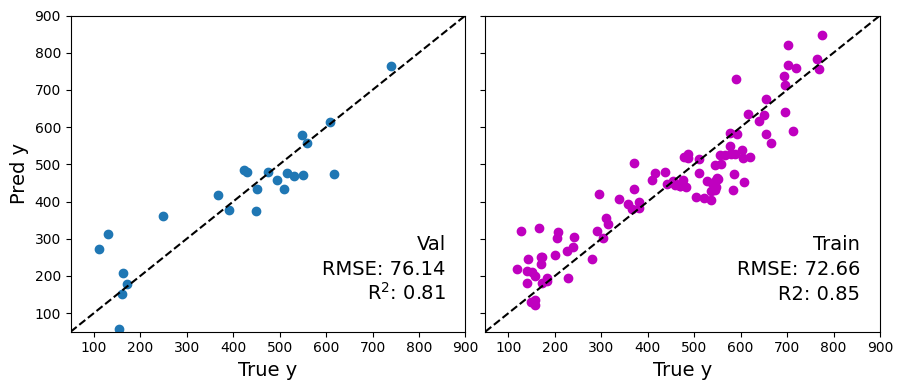

Root Mean squared error: 76.14
Coefficient of determination: 0.81


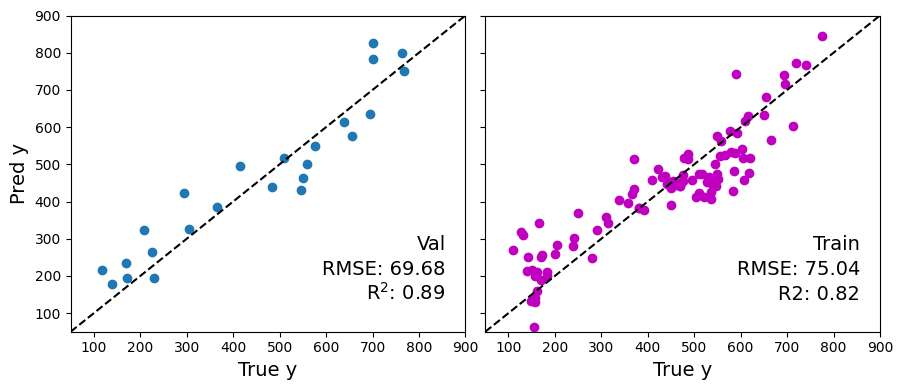

Root Mean squared error: 69.68
Coefficient of determination: 0.89


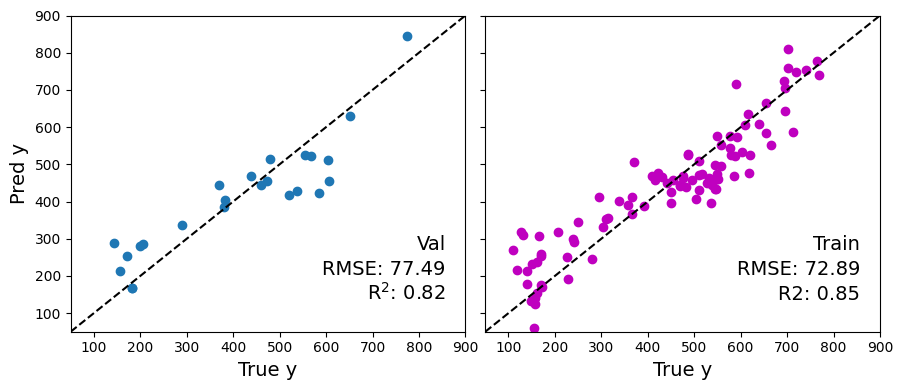

Root Mean squared error: 77.49
Coefficient of determination: 0.82


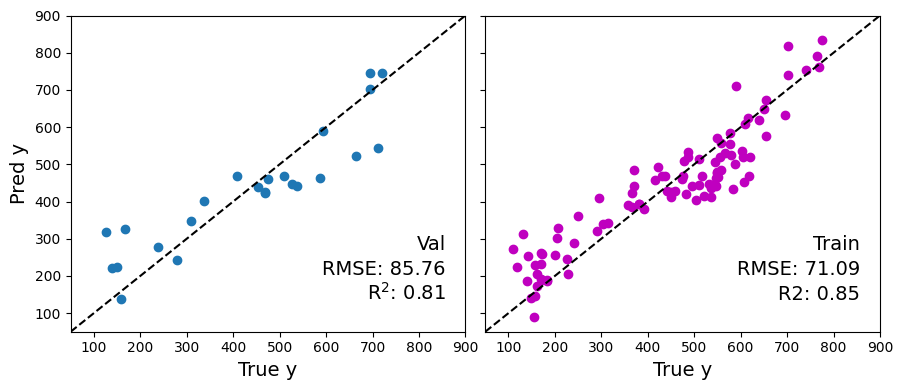

Root Mean squared error: 85.76
Coefficient of determination: 0.81


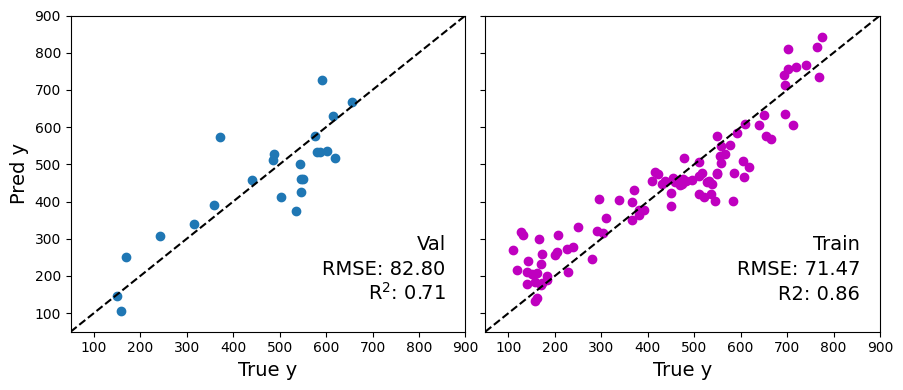

Root Mean squared error: 82.80
Coefficient of determination: 0.71


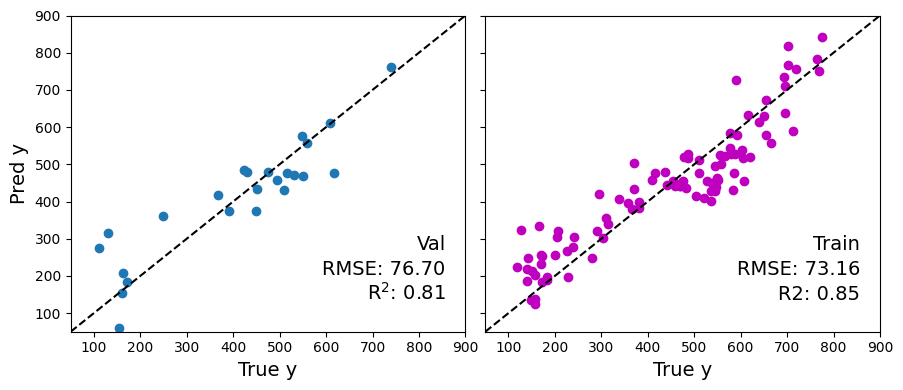

Root Mean squared error: 76.70
Coefficient of determination: 0.81


In [221]:
#c_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2, 3]

c_values = [1, 2, 3, 3.5, 4, 5, 6, 7, 8, 10]
errors_norm = []

for alp in c_values:
    pr_l2_norm = Ridge(alpha=alp)
    for idx, (train, val) in enumerate(kf.split(X)):
        _X_cv_train = X.values[train]
        _X_cv_val = X.values[val]

        X_cv_train = scaler.fit_transform(_X_cv_train)
        X_cv_val = scaler.transform(_X_cv_val)

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]


        # Model fit and prediction
        model = pr_l2_norm.fit(X_cv_train,y_cv_train)
        y_pred_val = model.predict(X_cv_val)
        y_pred_train = model.predict(X_cv_train)


        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
        rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

        r2_val = r2_score(y_cv_val, y_pred_val)
        r2_train = r2_score(y_cv_train, y_pred_train)


        # Plot Parity plot
        polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

        print("Root Mean squared error: %.2f" % rmse_val)
        print("Coefficient of determination: %.2f" % r2_val)

        error = {'c':alp,
                 'kfold': idx+1,
                 'rmse_train': rmse_train,
                 'rmse_val': rmse_val,
                 'r2_val': r2_val,
                 'r2_train': r2_train}

        errors_norm.append(error)

errors_norm = pd.DataFrame(errors_norm)

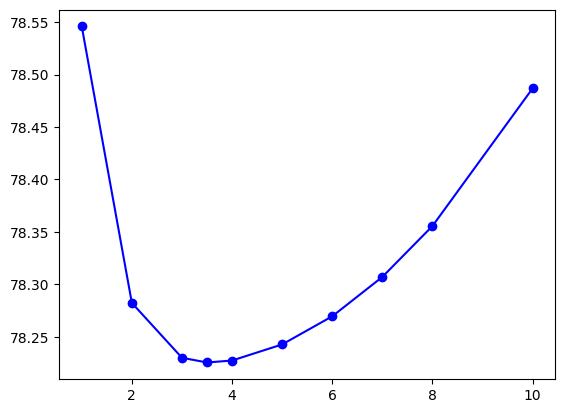

In [222]:
plt.plot(c_values, errors_norm.groupby('c').mean()['rmse_val'], '-bo')

In [223]:
c_grp_data = errors_norm.groupby('c').mean()
norm_c_opt = c_grp_data.index[c_grp_data['rmse_val'].argmin()]
errors_pr_norm = errors_norm.loc[errors_norm['c'] == norm_c_opt]
errors_pr_norm.mean()

c              3.500000
kfold          3.000000
rmse_train    70.689639
rmse_val      78.225624
r2_val         0.806483
r2_train       0.855226
dtype: float64

In [224]:
errors_l2_c_opt.mean()

kfold          3.000000
rmse_train    68.515345
rmse_val      80.164457
r2_val         0.784298
r2_train       0.863754
dtype: float64

## Question


Q1. Why normalization is done only on the train set during cross-validation?

* incase if we apply normalization on the whole datset the validation error would be less as the whole dataset is normalised but then when we test it on the test dataset their would be high error.


Q2. Is the optimized coefficient value same for the pristine and the normalized data? Why or why not?

 No, the optimised coeeficients may not be same because in pristine dataset the data is not in a specific range or region but the normalised data is reduced in a specific range.
 * There might be a feature from 1 to 1000 while another feature from 0 to 10 to fit the model the weights would vary too much which will not be in the case of normalised data as the values would be scaled.

### Recursive feature elimination

In [225]:
pr_l2_copt_rfe = Ridge(alpha=c_opt)
selector = RFECV(pr_l2_copt_rfe, step=1, cv=5, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)
sel_features = Xcols[selector.support_]

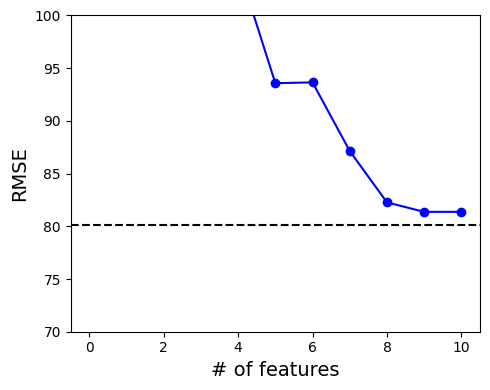

In [226]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(np.sqrt(selector.cv_results_['mean_test_score']*-1), '-bo')
ax1.axhline(errors_l2_c_opt.mean()['rmse_val'], linestyle='--', color='k')
ax1.set_ylim(70,100)
ax1.set_xlabel('# of features', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14)
plt.tight_layout()

In [227]:
print("Initial number of features", selector.n_features_in_)
print("Selected number of features", selector.n_features_)

Initial number of features 11
Selected number of features 11


In [228]:
rmse_rfe = np.sqrt((selector.cv_results_['mean_test_score']*-1).min())
print("Root Mean square error with RFE (eV^2): ", rmse_rfe)

Root Mean square error with RFE (eV^2):  81.37236281993209


In [229]:
sel_features

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni', 'n.1', 'n.2', 'n.3',
       'n.4', 'n.5'],
      dtype='object')

In [230]:
X = new_data[sel_features]

In [231]:
c_values = [0.0001, 0.0005, 0.00065, 0.0008, 0.001, 0.0012, 0.0014, 0.002, 0.01, 0.05, 0.1, 1, 2]
hyper_params = {'alpha':c_values}

pr_rfe_ridge = Ridge()
clf = GridSearchCV(pr_rfe_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

_ = clf.fit(X,y)

In [232]:
rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([ 80.37746946,  78.74822196,  78.5320316 ,  78.40731424,
        78.33075385,  78.3187628 ,  78.34695547,  78.55197774,
        81.34239268,  84.25826775,  85.24084833, 109.75686778,
       129.52780229])

Text(0, 0.5, 'RMSE')

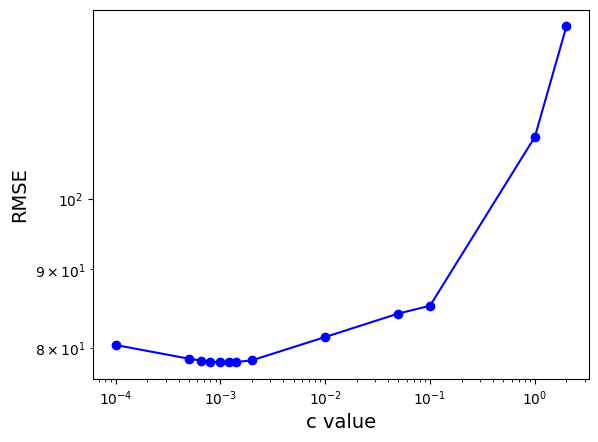

In [233]:
plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [234]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(0.0012, 78.31876280147227)

In [235]:
c_opt_rfe = c_values[min_idx]

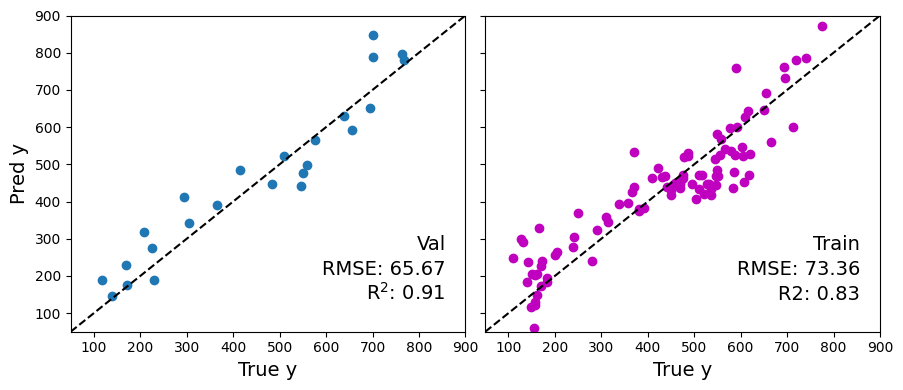

Root Mean squared error: 65.67
Coefficient of determination: 0.91


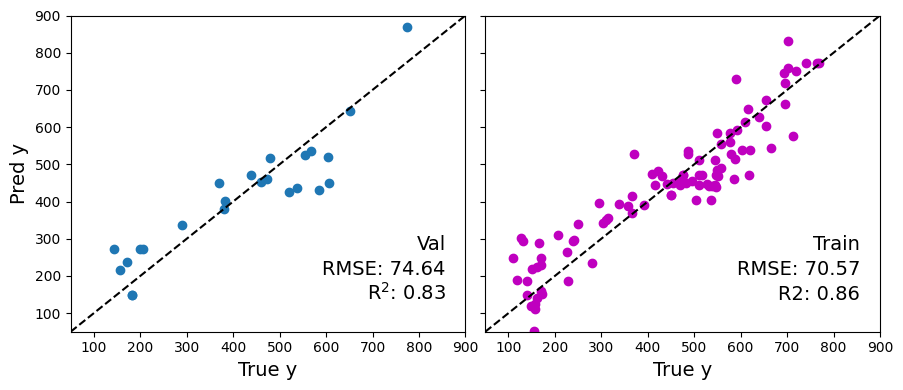

Root Mean squared error: 74.64
Coefficient of determination: 0.83


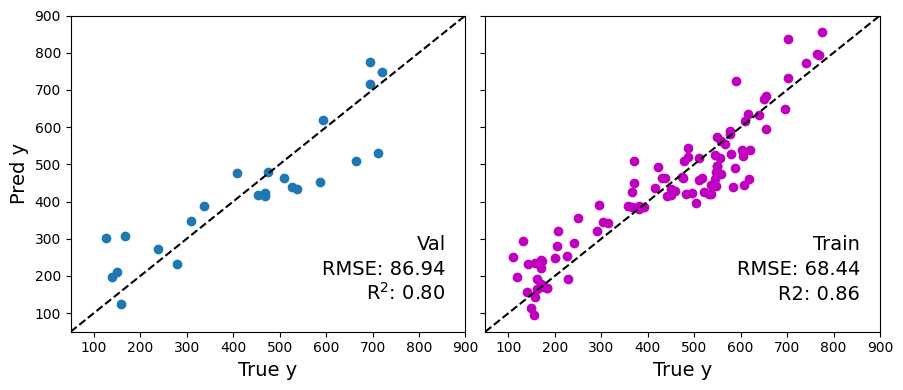

Root Mean squared error: 86.94
Coefficient of determination: 0.80


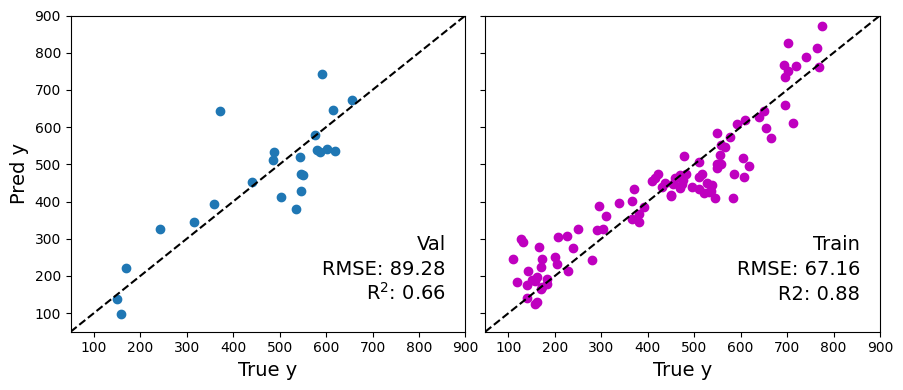

Root Mean squared error: 89.28
Coefficient of determination: 0.66


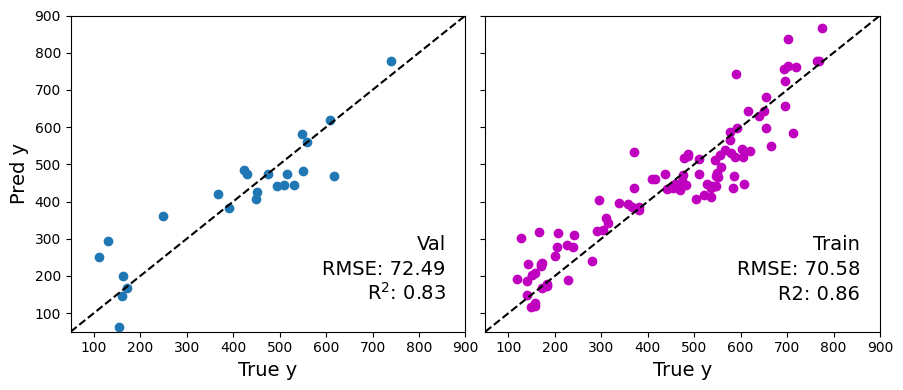

Root Mean squared error: 72.49
Coefficient of determination: 0.83


In [236]:
pr_rfe_c_opt = Ridge(alpha=c_opt_rfe)

errors_rfe_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = pr_rfe_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_rfe_c_opt.append(error)
errors_rfe_c_opt = pd.DataFrame(errors_rfe_c_opt)

In [237]:
errors_rfe_c_opt.mean()

kfold          3.000000
rmse_train    70.021150
rmse_val      77.805559
r2_val         0.806103
r2_train       0.857856
dtype: float64

In [238]:
errors_l2_c_opt.mean()

kfold          3.000000
rmse_train    68.515345
rmse_val      80.164457
r2_val         0.784298
r2_train       0.863754
dtype: float64

### Plot All errors

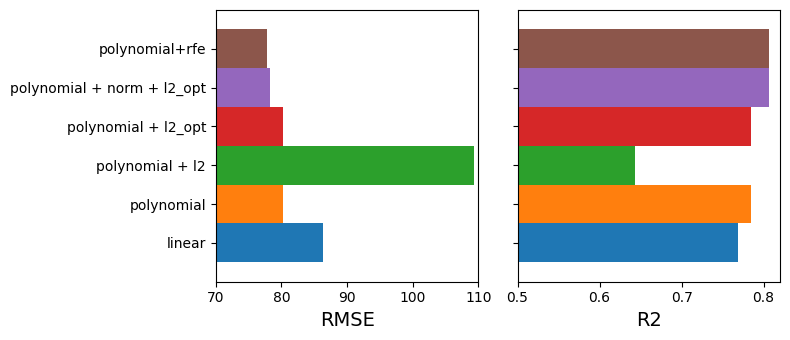

In [239]:
width = 0.1
labels = ['linear','polynomial','polynomial + l2','polynomial + l2_opt','polynomial + norm + l2_opt', 'polynomial+rfe']
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)

for idx,e in enumerate([errors, errors_pr, errors_pr_l2, errors_l2_c_opt, errors_pr_norm, errors_rfe_c_opt]):
    mse = e.mean()['rmse_val']
    r2 = e.mean()['r2_val']

    ax1.barh(0 + width*(idx-1), mse, height=width, label=labels[idx], align='center')
    ax2.barh(0 + width*(idx-1), r2, height=width, label=labels[idx], align='center')

ax1.set_xlabel('RMSE', fontsize=14)
ax2.set_xlabel('R2', fontsize=14)

ax1.set_yticks([-0.1,0,0.1,0.2, 0.3, 0.4])
ax1.set_yticklabels(labels)

ax1.set_ylim(-0.2,0.5)
ax1.set_xlim(70,110)
ax2.set_xlim(0.5,0.82)

plt.tight_layout()
plt.show()

In [247]:
Xcols = data.columns[data.columns.str.contains("C.")]
new_X = data[Xcols]
new_X


C.al      C.co      C.cr      C.cu      C.fe      C.ni
0    0.000000  0.250000  0.250000  0.000000  0.250000  0.250000
1    0.153846  0.307692  0.153846  0.076923  0.153846  0.153846
2    0.222222  0.111111  0.000000  0.222222  0.222222  0.222222
3    0.428571  0.214286  0.071429  0.071429  0.071429  0.142857
4    0.090909  0.181818  0.181818  0.181818  0.181818  0.181818
..        ...       ...       ...       ...       ...       ...
115  0.166667  0.333333  0.000000  0.166667  0.166667  0.166667
116  0.117647  0.000000  0.294118  0.000000  0.441176  0.147059
117  0.166667  0.250000  0.166667  0.083333  0.166667  0.166667
118  0.166667  0.166667  0.333333  0.000000  0.166667  0.166667
119  0.000000  0.212575  0.212575  0.212575  0.149701  0.212575

[120 rows x 6 columns]

## Question
Q3. Update the gradient decent code written in Assignmnet #2 to accomodate the regularization term. Are the learned coefficients still same for the numerical and the analytical methods? Discuss.

In [281]:
def gradient_descent_with_regularization(X, y, m, c, alpha, lambda_reg, epochs):
    n = len(y)
    X_transpose = X.T

    for i in range(epochs):
        predictions = np.dot(X, m) + c
        errors = y - predictions
        sum_delta_m = (-2 / n) * np.dot(X_transpose, errors)
        sum_delta_c = (-2 / n) * np.sum(errors)
        reg_term_m = 2*lambda_reg * m
        sum_delta_m += reg_term_m
        m -= alpha * sum_delta_m
        c -= alpha * sum_delta_c
    return m, c

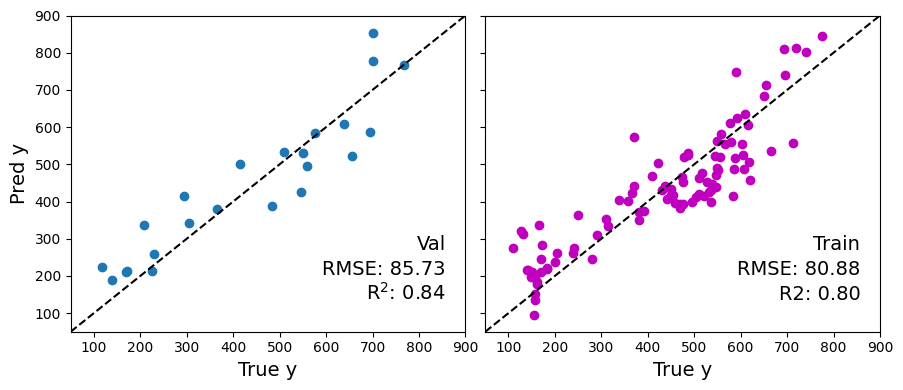

Root mean squared error: 85.73
Coefficient of determination: 0.84


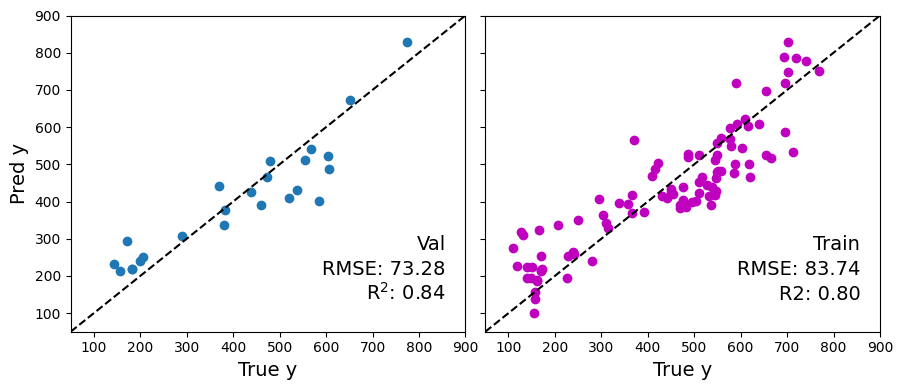

Root mean squared error: 73.28
Coefficient of determination: 0.84


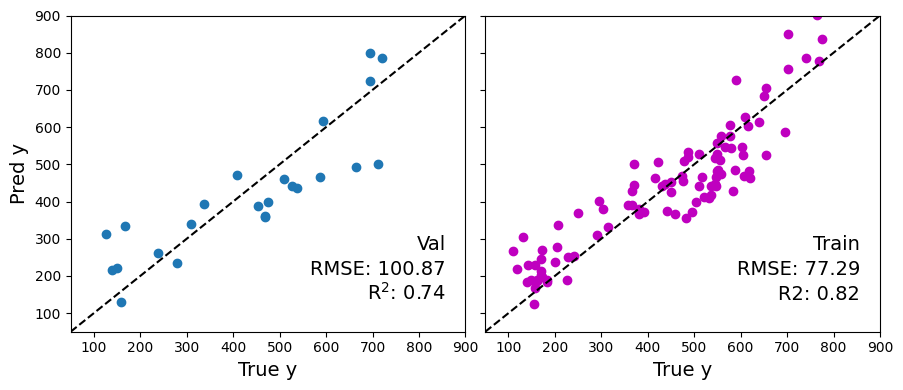

Root mean squared error: 100.87
Coefficient of determination: 0.74


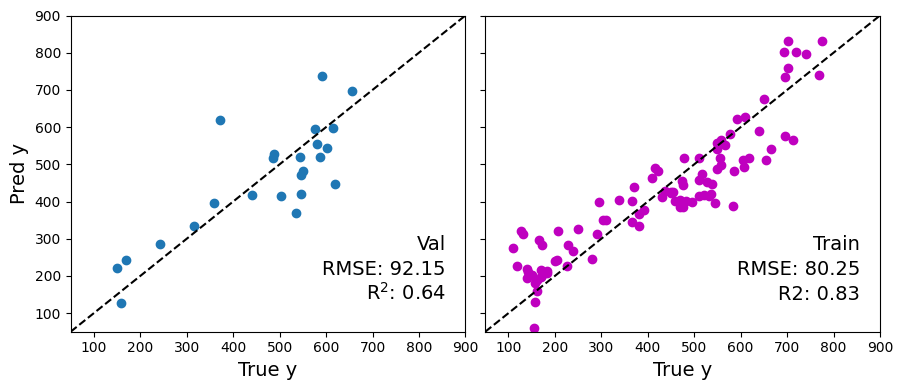

Root mean squared error: 92.15
Coefficient of determination: 0.64


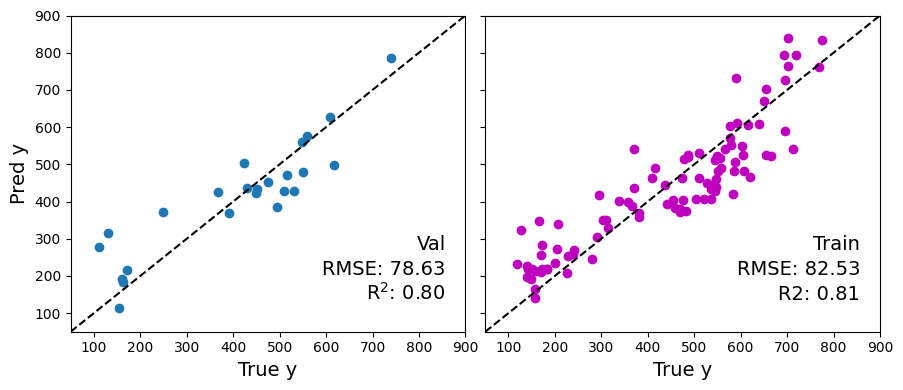

Root mean squared error: 78.63
Coefficient of determination: 0.80


In [282]:
kf = KFold(n_splits=5)

errors = []
average_m = [0,0,0,0,0,0]

for idx, (train, val) in enumerate(kf.split(new_X)):

    X_cv_train = new_X.values[train]
    X_cv_val = new_X.values[val]
    y_cv_train = y.values[train]
    y_cv_val = y.values[val]

    m = np.zeros(X_cv_train.shape[1])
    c = 0
    learning_rate = 0.006
    lambda_reg = 0.00001
    epochs = 50000

    m, c = gradient_descent_with_regularization(X_cv_train, y_cv_train, m, c, learning_rate, lambda_reg, epochs)

    for i in range(0,6):
      average_m[i]+=m[i]

    y_pred_val = X_cv_val.dot(m) + c
    y_pred_train = X_cv_train.dot(m) + c

    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)

    polt_parity(y_cv_val, y_pred_val, y_cv_train, y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)



In [283]:
for i in range(len(average_m)):
  average_m[i]/=5

In [284]:
assign_errors = pd.DataFrame(errors)
assign_errors[['rmse_val','r2_val']].mean()

rmse_val    86.131210
r2_val       0.769981
dtype: float64

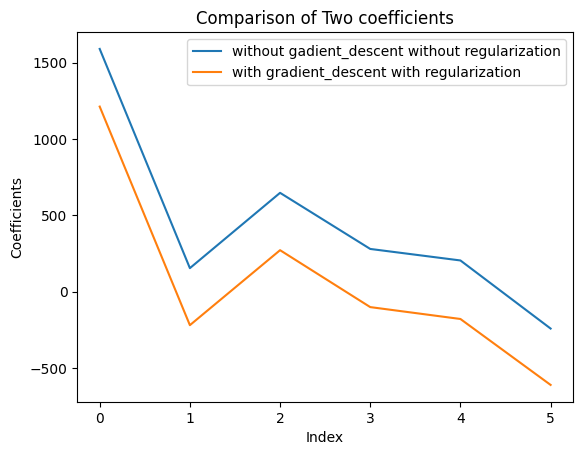

In [285]:
import matplotlib.pyplot as plt

plt.plot(w_cap_vec, label='without gadient_descent without regularization')
plt.plot(average_m, label='with gradient_descent with regularization')

plt.xlabel('Index')
plt.ylabel('Coefficients')
plt.title('Comparison of Two coefficients')
plt.legend()

plt.show()

* The coefficients for regularised is generally lower than the unregularized one as it is responsible to lower the parameter values. It is also responsible to prevent overfitting.
* Analytical method is more feasible compared to the numerical method as the numerical method converges slowly towards the solution while analytical method provides direct solution.

#### For selection of lamda term for regularization


In [314]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def gradient_descent_with_regularization(X, y, m, c, alpha, lambda_reg, epochs):
    n = len(y)
    X_transpose = X.T

    for i in range(epochs):
        predictions = np.dot(X, m) + c
        errors = y - predictions

        sum_delta_m = (-2 / n) * np.dot(X_transpose, errors)
        sum_delta_c = (-2 / n) * np.sum(errors)

        reg_term_m = 2 * lambda_reg * m
        sum_delta_m += reg_term_m

        m -= alpha * sum_delta_m
        c -= alpha * sum_delta_c

    return m, c

lambdas = [0.00001, 0.00003, 0.0005, 0.0001, 0.0003, 0.0002]

results = []

for lambda_reg in lambdas:

    kf = KFold(n_splits=5)
    errors = {'lambda': lambda_reg, 'rmse_train': [], 'r2_train': [], 'rmse_val': [], 'r2_val': []}

    for idx, (train, val) in enumerate(kf.split(new_X)):
        X_cv_train = new_X.values[train]
        X_cv_val = new_X.values[val]
        y_cv_train = y.values[train]
        y_cv_val = y.values[val]
        m = np.zeros(X_cv_train.shape[1])

        c = 0
        learning_rate = 0.006
        epochs = 50000

        m, c = gradient_descent_with_regularization(X_cv_train, y_cv_train, m, c, learning_rate, lambda_reg, epochs)

        y_pred_val = X_cv_val.dot(m) + c
        y_pred_train = X_cv_train.dot(m) + c

        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
        rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

        r2_val = r2_score(y_cv_val, y_pred_val)
        r2_train = r2_score(y_cv_train, y_pred_train)

        errors['rmse_train'].append(rmse_train)
        errors['r2_train'].append(r2_train)
        errors['rmse_val'].append(rmse_val)
        errors['r2_val'].append(r2_val)

    results.append(errors)


for result in results:
    print("Lambda:", result['lambda'])
    print("Average RMSE (Train):", np.mean(result['rmse_train']))
    print("Average R2 Score (Train):", np.mean(result['r2_train']))
    print("Average RMSE (Validation):", np.mean(result['rmse_val']))
    print("Average R2 Score (Validation):", np.mean(result['r2_val']))
    print()



Lambda: 1e-05
Average RMSE (Train): 80.93538632327575
Average R2 Score (Train): 0.81068616259063
Average RMSE (Validation): 86.1312099009571
Average R2 Score (Validation): 0.769980798620359

Lambda: 3e-05
Average RMSE (Train): 80.9372490447543
Average R2 Score (Train): 0.8106773367667219
Average RMSE (Validation): 86.11851572737936
Average R2 Score (Validation): 0.7700720229331187

Lambda: 0.0005
Average RMSE (Train): 81.17623559171635
Average R2 Score (Train): 0.8095540155209999
Average RMSE (Validation): 86.04703759971662
Average R2 Score (Validation): 0.7710455227890389

Lambda: 0.0001
Average RMSE (Train): 80.94946824223345
Average R2 Score (Train): 0.810619744232546
Average RMSE (Validation): 86.08069474282078
Average R2 Score (Validation): 0.7703571603028665

Lambda: 0.0003
Average RMSE (Train): 81.03095815014919
Average R2 Score (Train): 0.8102368066738951
Average RMSE (Validation): 86.0267297558181
Average R2 Score (Validation): 0.7708927468461486

Lambda: 0.0002
Average RMSE (